<h1 align="center">Agent Framework — Complete Tutorial</h1>

<p align="start">
A hands-on walkthrough of the <strong>Microsoft Agent Framework (Python SDK)</strong> — from a single agent to production-ready multi-agent workflows. Every section builds on the last, using an <strong>InboxOps</strong> e-commerce support scenario as the running example.
</p>

---

## What You'll Build

Starting from a bare-bones chat agent, we incrementally add capabilities until we have a full multi-agent system with orchestration, memory, human oversight, and evaluation:

| Section | What It Covers |
|---------|----------------|
| **1** | **Single Agent** — create an agent that reads an email and drafts a reply |
| **2** | **Streaming** — stream tokens in real time for a live drafting UX |
| **3** | **Threads** — conversation history across multiple turns |
| **4** | **Tools** — connect agents to internal APIs using `@tool` |
| **5** | **Multimodal Input** — accept images and attachments alongside text |
| **6** | **Structured Output** — return Pydantic models instead of free text |
| **7** | **MCP Integration** — connect to external systems via hosted MCP servers |
| **8** | **Human-in-the-Loop** — approval gates before risky actions execute |
| **9** | **Middleware** — logging, timing, and observability hooks |
| **10** | **Error Handling & Retry** — exponential backoff and circuit breaker patterns |
| **11** | **Memory** — `ContextProvider` for cross-thread knowledge that persists across conversations |
| **12** | **Sequential Workflow** — agents execute in a fixed pipeline (classify → draft → review) |
| **13** | **Concurrent Workflow** — fan-out / fan-in with parallel agents and an aggregator |
| **14** | **Group Chat** — round-robin and orchestrator-led multi-agent discussions |
| **15** | **Magentic Orchestration** — dynamic planning with plan/review loops and HITL approval |
| **16** | **Handoff** — peer-to-peer agent routing with autonomous mode and tool use |

Each orchestration section includes a **PNG workflow visualization** generated with `WorkflowViz`.

---

## What is an Agent?

![What is an Agent](images/what-is-agent.png)

Unlike traditional LLM deployments that simply respond to prompts, agents follow the **ReAct pattern** (Reasoning + Acting):

| Traditional LLM | Agent (ReAct) |
|-----------------|---------------|
| Input → Output | Input → Reason → Act → Observe → Repeat |
| Single response | Multi-step execution |
| No tool access | Tool integration |
| Stateless | Memory & context |

Agents autonomously decide *what* to do, *which* tools to use, and *when* to stop.

---

## Prerequisites


- **Azure subscription** with Azure OpenAI access- **Graphviz** — required for workflow visualizations (`brew install graphviz` on macOS, `sudo apt install graphviz` on Linux)

- **Azure OpenAI resource** with a deployed model (e.g., `gpt-4o-mini`)- **Python 3.10+**
- **Azure CLI** installed and authenticated (`az login`)

# Environment Setup (InboxOps Internal Dev Environment)

InboxOps is prototyping a Support Email Copilot using Azure OpenAI and the Microsoft Agent Framework.

This notebook assumes:
- You have access to an Azure OpenAI resource
- A model deployment exists (example: `gpt-4o-mini`)
- You can authenticate with Azure CLI (`az login`)
- Python 3.10+

> The goal is to keep the demo reproducible for developers and consistent across environments.

## Create Virtual Environment

Run the following in your terminal to set up the environment:

```bash
python3.10 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

Or run the cell below to install dependencies directly.

In [1]:
# Create and configure the virtual environment (run once)
import subprocess
import shutil

def find_python():
    """Find a Python 3.10+ interpreter on the system."""
    # Check common Python commands in order of preference
    candidates = [
        "python3.13", "python3.12", "python3.11", "python3.10",
        "python3", "python"
    ]
    
    for cmd in candidates:
        path = shutil.which(cmd)
        if path:
            # Verify version is 3.10+
            try:
                result = subprocess.run(
                    [path, "-c", "import sys; print(f'{sys.version_info.major}.{sys.version_info.minor}')"],
                    capture_output=True, text=True
                )
                version = result.stdout.strip()
                major, minor = map(int, version.split('.'))
                if major >= 3 and minor >= 10:
                    return path, version
            except:
                continue
    
    raise RuntimeError("No Python 3.10+ found. Please install Python 3.10 or higher.")

# Find suitable Python
python_path, python_version = find_python()
print(f"✅ Found Python {python_version}: {python_path}")

# Create .venv
subprocess.run([python_path, "-m", "venv", ".venv"])

# Install requirements with pre-release flag
subprocess.run([".venv/bin/pip", "install", "-r", "requirements.txt", "--pre"])

print("\n✅ Virtual environment created at .venv")
print("   Activate with: source .venv/bin/activate")

✅ Found Python 3.12: /Users/glswht/Desktop/magentic-workflow/agent-framework/.venv/bin/python3.12

✅ Virtual environment created at .venv
   Activate with: source .venv/bin/activate



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Install Graphviz system binary (required for PNG workflow visualizations)
import platform, subprocess, shutil

if shutil.which("dot"):
    result = subprocess.run(["dot", "-V"], capture_output=True, text=True)
    print(f"✅ Graphviz already installed: {(result.stderr or result.stdout).strip()}")
else:
    system = platform.system()
    if system == "Darwin":
        print("🍎 macOS detected — installing Graphviz via Homebrew...")
        subprocess.run(["brew", "install", "graphviz"], check=True)
    elif system == "Windows":
        print("🪟 Windows detected — installing Graphviz via winget...")
        subprocess.run(["winget", "install", "--id", "Graphviz.Graphviz", "--accept-source-agreements"], check=True)
        print("⚠️  You may need to restart your terminal/VS Code for 'dot' to be on PATH.")
    elif system == "Linux":
        print("🐧 Linux detected — installing Graphviz via apt...")
        subprocess.run(["sudo", "apt-get", "install", "-y", "graphviz"], check=True)
    else:
        print(f"❌ Unknown OS ({system}). Install Graphviz manually: https://graphviz.org/download/")

    # Verify
    if shutil.which("dot"):
        print("✅ Graphviz installed successfully!")
    else:
        print("⚠️  'dot' not found on PATH yet. Restart your terminal or add Graphviz to PATH.")

✅ Graphviz already installed: dot - graphviz version 14.1.2 (20260124.0452)


## Initialize the InboxOps Chat Client

We create **one shared Azure OpenAI client** and reuse it across the entire notebook.

This mirrors how InboxOps would run a long-lived backend service:
- The service initializes once
- Agents are created from the same client
- Tool calls, workflows, memory, and orchestration all share the same foundation

In [3]:
from agent_framework_azure_ai import AzureAIAgentClient
import nest_asyncio
nest_asyncio.apply()

import os
import asyncio
from dotenv import load_dotenv
from agent_framework.azure import AzureOpenAIChatClient
from azure.identity.aio import DefaultAzureCredential

# Load environment variables
load_dotenv()

# Create ONE chat client - reused throughout the notebook
# Routed through APIM gateway; base_url bypasses the SDK's automatic /openai prefix
chat_client = AzureOpenAIChatClient(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    base_url=f"{os.environ['AZURE_OPENAI_ENDPOINT']}/deployments/{os.environ['AZURE_OPENAI_CHAT_DEPLOYMENT_NAME']}",
    api_version=os.environ.get("API_VERSION", "2025-01-01-preview"),
)

# AzureAIAgentClient uses DefaultAzureCredential (token-based auth required by the Agent Service)
# Auth resolves automatically: service-principal env vars → managed identity → az login
chat_client_mcp = AzureAIAgentClient(
    project_endpoint=os.environ["AZURE_AI_PROJECT_ENDPOINT"],
    credential=DefaultAzureCredential(),
)

print("✅ Environment loaded and chat_client created")

✅ Environment loaded and chat_client created


## Data Models (InboxOps Message Contracts)

InboxOps wants predictable, structured outputs—not messy free-text.

We define Pydantic schemas used across the system:
- Incoming email structure (`EmailInput`)
- Classification outputs (`ClassificationResult`)
- Draft response formats (`DraftResponse`)
- Final approval structure (`FinalResponse`)

> These schemas represent the "API contracts" between our agents, tools, and workflows.

In [4]:
from typing import Literal, Annotated
from pydantic import BaseModel, Field

# === Input Model ===
class EmailInput(BaseModel):
    """Incoming support email."""
    sender: str = Field(description="Email sender address")
    subject: str = Field(description="Email subject line")
    body: str = Field(description="Email body content")
    customer_id: str | None = Field(default=None, description="Customer ID if known")
    ticket_id: str | None = Field(default=None, description="Related ticket ID if any")

# === Classification Model ===
class ClassificationResult(BaseModel):
    """Result of email classification."""
    category: Literal["spam", "not_spam", "uncertain"] = Field(description="Email category")
    confidence: float = Field(ge=0.0, le=1.0, description="Confidence score 0-1")
    reason: str = Field(description="Brief explanation of classification")

# === Draft Response Model ===
class DraftResponse(BaseModel):
    """Draft reply to customer email."""
    subject: str = Field(description="Reply subject line")
    body: str = Field(description="Reply body")
    tone: Literal["formal", "friendly", "apologetic"] = Field(description="Tone used")
    needs_review: bool = Field(default=False, description="Flag if needs human review")

# === Final Response Model ===
class FinalResponse(BaseModel):
    """Final approved response."""
    classification: ClassificationResult
    draft: DraftResponse | None = Field(default=None, description="Draft if not spam")
    review_notes: str | None = Field(default=None, description="Reviewer comments")
    approved: bool = Field(default=False, description="Whether approved to send")

print("✅ Shared models defined: EmailInput, ClassificationResult, DraftResponse, FinalResponse")

✅ Shared models defined: EmailInput, ClassificationResult, DraftResponse, FinalResponse


## Sample InboxOps Emails

We'll use three realistic email types to simulate real inbox traffic:

✅ Legitimate Customer Issue — should generate a helpful response  
🚫 Spam Message — should be blocked  
⚠️ Ambiguous Request — should be routed for human review  

> This is exactly what InboxOps sees daily at scale.

In [5]:
# === LEGITIMATE EMAIL ===
LEGIT_EMAIL = EmailInput(
    sender="sarah.chen@acmecorp.com",
    subject="Order #12345 - Delivery Issue",
    body="""Hi Support Team,

I placed order #12345 last week and the tracking shows it was delivered, 
but I never received the package. I've checked with my neighbors and the building 
concierge, but no one has seen it.

This is urgent as the items were needed for a client presentation on Friday.
Can you please help me locate the package or arrange a replacement?

Thank you,
Sarah Chen
Account: ACME-7891
""",
    customer_id="CUST-7891",
    ticket_id="TKT-2024-001"
)

# === SPAM EMAIL ===
SPAM_EMAIL = EmailInput(
    sender="winner@prize-notifications.biz",
    subject="🎉 CONGRATULATIONS! You've WON $1,000,000!!!",
    body="""URGENT NOTIFICATION!!!

You have been selected as the WINNER of our international lottery!
To claim your $1,000,000 prize, simply send your bank details and 
a processing fee of $500 to unlock your winnings.

ACT NOW - This offer expires in 24 HOURS!!!

Click here to claim: http://totally-legit-prize.com/claim
""",
    customer_id=None,
    ticket_id=None
)

# === AMBIGUOUS EMAIL ===
AMBIGUOUS_EMAIL = EmailInput(
    sender="j.smith@unknown-domain.net",
    subject="Partnership Opportunity",
    body="""Hello,

I found your company online and I'm interested in discussing a potential 
business partnership. We have a new product line that might complement your services.

Can we schedule a call this week?

Best,
J. Smith
""",
    customer_id=None,
    ticket_id=None
)

print("✅ Sample emails defined: LEGIT_EMAIL, SPAM_EMAIL, AMBIGUOUS_EMAIL")

✅ Sample emails defined: LEGIT_EMAIL, SPAM_EMAIL, AMBIGUOUS_EMAIL


# 1. Single Agent

![Agent Components](images/agent-components.png)

InboxOps starts with the simplest solution:

**One agent that reads an email and drafts a reply.**

This already provides value:
- Faster draft creation
- More consistent tone
- Reduced repetitive typing for support reps

The next cell creates a `SupportAgent` using `chat_client.as_agent()` and runs it against a customer email.

In [6]:
# Create the core Support Agent - we'll enhance this throughout the notebook
support_agent = chat_client.as_agent(
    name="SupportAgent",
    instructions="""You are a helpful customer support agent for an e-commerce company.
Your job is to:
1. Understand customer issues from their emails
2. Draft professional, empathetic responses
3. Provide clear next steps when possible

Always be polite, acknowledge the customer's frustration, and offer concrete solutions."""
)

print("✅ support_agent created")

✅ support_agent created


## Run the SupportAgent

The cell below calls `support_agent.run()` with the legitimate email and prints the draft response.

**Input:** customer email  
**Output:** draft reply

In [7]:
# Run the support agent on our legitimate email
async def run_basic_agent():
    prompt = f"""Please draft a response to this customer email:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}

{LEGIT_EMAIL.body}
"""
    result = await support_agent.run(prompt)
    print("📧 Draft Response:\n")
    print(result.text)

asyncio.run(run_basic_agent())

📧 Draft Response:

Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

Thank you for reaching out to us regarding your order #12345. I’m very sorry to hear that you haven’t received your package despite the tracking indicating that it has been delivered. I can understand how concerning this must be, especially with your client presentation approaching.

To assist you in resolving this matter quickly, I recommend the following steps:

1. **Contact the Carrier**: Sometimes, delivery carriers can provide further details about the delivery location. If you can, please check the delivery status directly with them.

2. **File a Claim**: If the carrier cannot provide a resolution, we can assist you in filing a claim for the missing package. This is an essential step in recovering lost items.

3. **Replacement Order**: Should the package remain unlocated, we can arrange for a replacement order to be sent out immediately. Please confirm if you would like to proceed with this option.

Pleas

# 2. Streaming Responses

InboxOps support reps don't want to wait for a full answer.

They want a **live drafting experience**:
- The response appears token-by-token
- It feels interactive, like a "Copilot"
- Faster perceived performance

The cell below calls `support_agent.run_stream()` and prints each token as it arrives.

In [8]:
### Stream the response token by token using the SAME support_agent
async def stream_support_response():
    prompt = f"""Please draft a response to this customer email:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}

{LEGIT_EMAIL.body}
"""
    print("📧 Streaming Draft Response:\n")
    async for update in support_agent.run_stream(prompt):
        if update.text:
            print(update.text, end="", flush=True)
    print()  # New line after streaming

asyncio.run(stream_support_response())

📧 Streaming Draft Response:

Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

Thank you for reaching out to us regarding your order #12345. I understand how distressing it must be to have not received your package, especially with your client presentation approaching. I'm here to assist you in resolving this issue as quickly as possible.

First, I recommend double-checking the delivery address on your order to ensure it was sent to the correct location. Additionally, sometimes packages can be left in secure areas around the property or may have been taken back to the local delivery center if no one was available to receive them.

In the meantime, I will initiate an investigation with our shipping carrier to locate your package. This process can take a few days, but I promise to keep you updated on any new information.

Given the urgency of your situation, I can also arrange to send a replacement for the items in your order. If you would like to proceed with that, please let me 

# 3. Threads

![Threads and Memory](images/threads-and-memory.png)

Customers don't send only one email. They follow up:
- "Any updates?"
- "This is urgent"
- "I already tried that"

By default, agents are stateless. **Threads** preserve context across multiple turns.

The cells below create a thread with `agent.get_new_thread()`, run two turns against it (summarize then draft), and show that the agent remembers context from the first turn.

## Using Threads

The cell below creates a thread with `agent.get_new_thread()`, runs two turns (summarize then draft), and shows the agent using context from the first turn in the second.

In [9]:
# Create a thread for multi-turn conversation
thread = support_agent.get_new_thread()

# Turn 1: Summarize the customer issue
print("Turn 1: Summarize the issue")
print("-" * 50)
result1 = await support_agent.run(
    f"Summarize the key issues in this email in 2-3 bullet points:\n\n{LEGIT_EMAIL.body}", 
    thread=thread
)
print(result1.text)
print()

# Turn 2: Draft a response (agent remembers the summary from Turn 1)
print("Turn 2: Draft response with professional tone")
print("-" * 50)
result2 = await support_agent.run(
    "Now draft a professional response addressing each of those issues. Use a formal but empathetic tone.",
    thread=thread
)
print(result2.text)

Turn 1: Summarize the issue
--------------------------------------------------
- Sarah's order #12345 shows as delivered, but she has not received the package despite checking with neighbors and the building concierge.
- The items were needed for a client presentation on Friday, making this issue urgent.
- She is requesting assistance to locate the package or arrange a replacement.

Turn 2: Draft response with professional tone
--------------------------------------------------
Subject: Re: Urgent Assistance Needed for Order #12345

Dear Sarah,

Thank you for reaching out to us regarding your order #12345. I sincerely apologize for the inconvenience you are experiencing with the delivery, especially given the urgency of your upcoming client presentation.

I understand how critical it is to have your items on time. To assist you further, I will initiate an investigation into your delivery status to help locate your package. This process may take a little time, but I will keep you update

# 4. Tools

A drafting agent is helpful — but a production support assistant must also be **correct**.

InboxOps needs the agent to reference real internal data, not guess:
- SLA tier (Premium vs Standard)
- Current ticket status (Open/Resolved)
- Prior actions already taken

We expose internal functions as tools using `@tool`. The agent autonomously decides when tool calls are needed.

The next cells define two tools (`lookup_customer_sla`, `get_incident_status`), attach them to an agent, and run it.

## Define InboxOps Tools

The cell below defines two tools using `@tool`:
- `lookup_customer_sla` — returns SLA tier and policies from a simulated CRM
- `get_incident_status` — returns ticket status from a simulated ticketing system

> The Agent Framework turns Python functions into callable tools that the agent invokes autonomously.

In [10]:
from agent_framework import tool
# Simulated database of customer SLAs
CUSTOMER_SLAS = {
    "CUST-7891": {"tier": "Premium", "response_time": "4 hours", "replacement_policy": "Free expedited replacement"},
    "CUST-1234": {"tier": "Standard", "response_time": "24 hours", "replacement_policy": "Standard replacement"},
}

# Simulated ticket database
TICKET_STATUSES = {
    "TKT-2024-001": {"status": "Open", "priority": "High", "assigned_to": "Support Team", "last_update": "2024-01-15"},
    "TKT-2024-002": {"status": "Resolved", "priority": "Low", "assigned_to": "Bot", "last_update": "2024-01-10"},
}

@tool(name="lookup_customer_sla", description="Look up a customer's SLA tier and policies")
def lookup_customer_sla(
    customer_id: Annotated[str, Field(description="The customer ID to look up (e.g., CUST-7891)")]
) -> str:
    """Look up customer SLA information."""
    if customer_id in CUSTOMER_SLAS:
        sla = CUSTOMER_SLAS[customer_id]
        return f"Customer {customer_id}: {sla['tier']} tier, {sla['response_time']} response time, {sla['replacement_policy']}"
    return f"Customer {customer_id} not found in system."

@tool(name="get_incident_status", description="Get the current status of a support ticket")
def get_incident_status(
    ticket_id: Annotated[str, Field(description="The ticket ID to check (e.g., TKT-2024-001)")]
) -> str:
    """Get ticket status information."""
    if ticket_id in TICKET_STATUSES:
        ticket = TICKET_STATUSES[ticket_id]
        return f"Ticket {ticket_id}: Status={ticket['status']}, Priority={ticket['priority']}, Assigned to={ticket['assigned_to']}, Last update={ticket['last_update']}"
    return f"Ticket {ticket_id} not found in system."

print("✅ Support tools defined: lookup_customer_sla, get_incident_status")

✅ Support tools defined: lookup_customer_sla, get_incident_status


## Attach Tools to Agent

The cell below creates `support_agent_with_tools` with the two tools from above, so the agent can look up SLA and ticket data during its response.

In [11]:
# Create support agent with tools
support_agent_with_tools = chat_client.as_agent(
    name="SupportAgentWithTools",
    instructions="""You are a customer support agent with access to internal systems.
When handling emails:
1. Look up the customer's SLA tier to understand their service level
2. Check ticket status if a ticket ID is mentioned
3. Use this information to provide appropriate responses and set expectations

Always be empathetic and use the customer's SLA tier to guide your response (e.g., Premium customers get expedited service).""",
    tools=[lookup_customer_sla, get_incident_status]
)

print("✅ support_agent_with_tools created")

✅ support_agent_with_tools created


## Execute with Tools

The cell below runs the agent on the legitimate email. The agent autonomously calls `lookup_customer_sla` and `get_incident_status` before drafting its response.

In [12]:
# Test with the legitimate email that has customer_id and ticket_id
prompt = f"""Handle this customer support email. Look up their SLA and ticket status first:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}
Customer ID: {LEGIT_EMAIL.customer_id}
Ticket ID: {LEGIT_EMAIL.ticket_id}

{LEGIT_EMAIL.body}
"""

result = await support_agent_with_tools.run(prompt)
print("📧 Response (with tool lookups):\n")
print(result.text)

📧 Response (with tool lookups):

Subject: Re: Order #12345 - Delivery Issue

Hi Sarah,

Thank you for reaching out, and I sincerely apologize for the inconvenience you're experiencing with your order. I understand how urgent this is, especially with your client presentation on Friday.

I can confirm that you are part of our Premium tier, which allows for expedited service. Your current ticket (TKT-2024-001) is open and has a high priority. Our support team is actively investigating the situation.

In the meantime, we can arrange for a replacement to be sent out to you. I’ll initiate that process right away. 

Please allow us a few hours to follow up with more details regarding the delivery issue and the replacement.

Thank you for your patience, and we’ll do our best to resolve this promptly!

Best regards,

[Your Name]  
Customer Support Team


# 5. Multimodal Input

InboxOps customers often attach **error screenshots** instead of describing problems in text:

> "My checkout isn't working" + 🖼️ `error_screenshot.png`

The Agent Framework supports multimodal input using `Content` objects. The cell below creates a multimodal message combining text and an image, then runs it through a `MultimodalSupportAgent`.


In [13]:
# Create a specialized Multimodal Support Agent for handling visual issues
multimodal_support_agent = chat_client.as_agent(
    name="MultimodalSupportAgent",
    instructions="""You are a specialized customer support agent with expertise in visual issue diagnosis.

IMPORTANT: When you receive an image, you MUST:
1. Acknowledge that you can see the image
2. Describe what you observe in the screenshot
3. Identify any error messages visible
4. Provide specific troubleshooting steps based on what you see

Your responsibilities:
- Analyze both textual descriptions and visual evidence (screenshots, images)
- Identify the exact error or problem from the visual content
- Provide step-by-step resolution instructions
- Consider visual context when recommending solutions
- Prioritize urgent issues and offer temporary workarounds

Be empathetic, solution-focused, and clear in your guidance."""
)

print("✅ multimodal_support_agent created")

# Load the customer's screenshot from local images folder
image_path = "images/customer_image.png"

print("\n📧 Email with screenshot received...")
print(f"📎 Attachment: {image_path}")

# Load the image from file
with open(image_path, "rb") as f:
    image_bytes = f.read()
print("\n" + "="*80 + "\n")

# Create a multimodal message with the local image
from agent_framework import ChatMessage, Content, Role

multimodal_message = ChatMessage(
    role=Role.USER,
    contents=[
        Content.from_text(text="What error do you see in this checkout screenshot? Describe the issue and provide troubleshooting steps."),
        Content.from_data(data=image_bytes, media_type="image/png")
    ]
)

# Run the specialized multimodal support agent - pass as messages list
print("🤖 Multimodal Support Agent analyzing email and screenshot...\n")
result = await multimodal_support_agent.run(messages=[multimodal_message])
print(result.text)

✅ multimodal_support_agent created

📧 Email with screenshot received...
📎 Attachment: images/customer_image.png


🤖 Multimodal Support Agent analyzing email and screenshot...

I can see the checkout screenshot you provided. 

### Observed Issue:
There's an error message indicated in pink below the "PLACE ORDER" button: 
**"There was an error processing your customer info. Please try again, or contact us if you continue to have problems."**

### Troubleshooting Steps:
1. **Check Customer Information**: 
   - Ensure all required fields (name, email, address, payment information) are filled out correctly. 
   - Look for any missing or incorrectly formatted information (e.g., invalid email format).

2. **Refresh the Page**:
   - Occasionally, a simple refresh can resolve temporary issues. Try refreshing the page and re-entering your details.

3. **Clear Browser Cache**:
   - Clear your browser's cache and cookies, as outdated or corrupted data can cause processing errors.
   - After cleari

# 6. Structured Output

After the agent drafts a response, InboxOps needs to:
- Create a ticket in the CRM with structured metadata
- Log priority, category, sentiment
- Route to the correct team

**Free-text agent output is hard to parse reliably.** Use `response_format` with a Pydantic model to enforce a JSON schema.

The cells below define a `TicketMetadata` model and create a `TicketMetadataExtractor` agent that returns structured JSON instead of free text.


In [14]:
from pydantic import BaseModel

class TicketMetadata(BaseModel):
    priority: str  # "low", "medium", "high", "urgent"
    category: str  # "order", "refund", "technical", etc.
    sentiment: str  # "positive", "neutral", "negative"
    estimated_resolution_time: str

agent = chat_client.as_agent(
    name="TicketMetadataExtractor",
    response_format=TicketMetadata  # Force structured output
)

The cell below defines a `TicketMetadata` Pydantic model, creates a `TicketMetadataExtractor` agent with `response_format=TicketMetadata`, runs it, and parses the structured JSON output.

In [15]:
from pydantic import BaseModel, Field

# Define ticket metadata schema
class TicketMetadata(BaseModel):
    """Structured metadata for InboxOps support tickets"""
    priority: str = Field(description="Priority level: low, medium, high, or urgent")
    category: str = Field(description="Ticket category: order, refund, technical, shipping, account, other")
    sentiment: str = Field(description="Customer sentiment: positive, neutral, or negative")
    estimated_resolution_time: str = Field(description="Estimated time to resolve (e.g., '1 hour', '24 hours', '3-5 days')")
    requires_human_review: bool = Field(description="Whether this ticket needs escalation to a human agent")

# Create a metadata extraction agent
metadata_agent = chat_client.as_agent(
    name="TicketMetadataExtractor",
    instructions="""You are an InboxOps ticket classification system.
    Extract structured metadata from customer support emails.
    Be accurate and consistent with your classifications.
    
    You must return JSON with these exact fields:
    - priority: low, medium, high, or urgent
    - category: order, refund, technical, shipping, account, or other
    - sentiment: positive, neutral, or negative
    - estimated_resolution_time: estimated time like "1 hour", "24 hours", "3-5 days"
    - requires_human_review: true or false""",
    response_format=TicketMetadata  # Enforce structured output
)

# Test with the legitimate email
test_email = LEGIT_EMAIL.body

print("📧 Extracting metadata from email...\n")
result = await metadata_agent.run(test_email)

# Debug: Show what the agent returned
print("🔍 Raw agent output:")
print(result.text)
print()

# Parse the structured output
metadata = TicketMetadata.model_validate_json(result.text)

print("📊 TICKET METADATA")
print("="*50)
print(f"Priority:              {metadata.priority}")
print(f"Category:              {metadata.category}")
print(f"Sentiment:             {metadata.sentiment}")
print(f"Est. Resolution Time:  {metadata.estimated_resolution_time}")
print(f"Needs Human Review:    {metadata.requires_human_review}")
print("\n✅ Structured output ready for CRM ingestion!")

📧 Extracting metadata from email...

🔍 Raw agent output:
{
    "priority": "urgent",
    "category": "shipping",
    "sentiment": "negative",
    "estimated_resolution_time": "1-2 hours",
    "requires_human_review": true
}

📊 TICKET METADATA
Priority:              urgent
Category:              shipping
Sentiment:             negative
Est. Resolution Time:  1-2 hours
Needs Human Review:    True

✅ Structured output ready for CRM ingestion!


# 7. MCP Integration

InboxOps uses **Zendesk** for ticketing, **Shopify** for orders, and **Stripe** for payments.

Instead of building custom API wrappers for each system, we use **Model Context Protocol (MCP)** — a standardized way to expose tools from external systems through `HostedMCPTool`.

### HostedMCPTool Parameters

```python
HostedMCPTool(
    name="ToolName",              # Display name for the MCP tool
    url="https://api.url/mcp",    # MCP server endpoint URL
    approval_mode="never_require", # Approval strategy (see below)
    headers={"Authorization": "Bearer token"}  # Optional HTTP headers
)
```

**Key Parameters:**

| Parameter | Type | Description |
|-----------|------|-------------|
| `name` | `str` | Human-readable name for the tool (shown in agent logs) |
| `url` | `str` | HTTP(S) endpoint of the MCP server |
| `approval_mode` | `str` | Controls human approval: `"never_require"` (auto-approve) or `"always_require"` (requires approval) |
| `headers` | `dict` | Optional HTTP headers for authentication (e.g., API keys, Bearer tokens) |

**Approval Modes:**
- `"never_require"` — Auto-approve all tool calls (good for read-only operations like documentation search)
- `"always_require"` — Pause execution and require human approval before each tool call (good for write operations like GitHub commits)

### Multiple MCP Tools Example

You can attach multiple MCP tools to a single agent, each with different approval policies:

```python
agent = chat_client.as_agent(
    name="MultiToolAgent",
    instructions="You can search docs and access GitHub repos.",
    tools=[
        HostedMCPTool(
            name="Microsoft Learn MCP",
            url="https://learn.microsoft.com/api/mcp",
            approval_mode="never_require",  # Safe read operations
        ),
        HostedMCPTool(
            name="GitHub MCP",
            url="https://api.githubcopilot.com/mcp",
            approval_mode="always_require",  # Requires approval
            headers={"Authorization": "Bearer github-token"},
        ),
    ],
)
```

The cell below creates a `HostedMCPTool` pointing at Microsoft Learn's MCP endpoint, attaches it to an agent, and queries Azure documentation.

In [16]:
from agent_framework import ChatAgent, HostedMCPTool, ChatMessage

# Recreate the MCP tool with auto-approval
learn_mcp_tool = HostedMCPTool(
    name="MicrosoftLearn",
    url="https://learn.microsoft.com/api/mcp",
    approval_mode="never_require"  # Auto-approve MCP tool calls
)

# Create the agent with the new tool
mcp_support_agent = ChatAgent(
    chat_client=chat_client_mcp,
    name="MCPSupportAgent",
    instructions="""You are a documentation assistant agent with access to Microsoft Learn documentation via MCP. 
When asked about Azure features, you MUST use the MCP tool to search for information.""",
    tools=[learn_mcp_tool],
)

# Test: Ask a very specific recent question that requires the MCP tool
test_request = """
A customer is asking: "What are the latest Azure AI Foundry features announced in January 2026?"

You MUST use the MCP tool to search for this information.
"""

print("🔌 MCP Agent with Microsoft Learn tool connection...")
print(f"Request: {test_request}\n")


result = await mcp_support_agent.run(test_request)


print(f"   Result text length: {len(result.text) if result.text else 0}")

print("\n📝 Agent Response:")
print("="*60)
print(result.text if result.text else "(empty response)")
print("\n" + "="*60)

🔌 MCP Agent with Microsoft Learn tool connection...
Request: 
A customer is asking: "What are the latest Azure AI Foundry features announced in January 2026?"

You MUST use the MCP tool to search for this information.


   Result text length: 1741

📝 Agent Response:
The latest features announced for Azure AI Foundry in January 2026 include:

1. **Orchestration Workflow Support in Microsoft Foundry (Classic)**:
   - A redesigned interface has been introduced to streamline integration between Conversational Language Understanding (CLU) and Custom Question Answering (CQA) projects.
   - This enhancement allows for efficient orchestration of user utterances across multiple conversational applications within a unified workflow and includes intent-based routing to improve query handling.

2. **Full Accessibility of Azure AI Language Capabilities**:
   - All Azure AI Language capabilities are now fully available in Microsoft Foundry (classic), providing a complete and unified development expe

# 8. Human-in-the-Loop Approval

Drafting is safe. **Sending an email is not.**

InboxOps policy:
✅ AI may draft responses  
🔒 A human must approve before sending  

We mark the sending tool with `approval_mode="always_require"`. The platform pauses execution, a human confirms or rejects, and only then can the workflow continue.

The cells below define a `send_email_reply` tool with approval, run it, inspect the pending approval, and then grant it.

## Approval-Required Action Tool

The cell below defines `send_email_reply` with `approval_mode="always_require"` and creates an `ApprovalSupportAgent` that uses it.

When the agent calls this tool, execution **pauses** until a human approves or rejects.

In [17]:
from agent_framework import ChatMessage, Content, Role

# Tool that requires human approval before sending
@tool(approval_mode="always_require", name="send_email_reply", description="Send an email reply to the customer. Requires human approval.")
def send_email_reply(
    to: Annotated[str, Field(description="Recipient email address")],
    subject: Annotated[str, Field(description="Email subject")],
    body: Annotated[str, Field(description="Email body content")]
) -> str:
    """Send an email reply to the customer. Requires human approval."""
    # In production, this would actually send the email
    return f"✅ Email sent to {to} with subject '{subject}'"

# Create agent with the approval-required tool
approval_agent = chat_client.as_agent(
    name="ApprovalSupportAgent",
    instructions="""You are a customer support agent. When you finish drafting a response, 
you MUST call the send_email_reply tool to send it. Do not ask for permission - just call the tool.
The system will automatically handle approval. Always use the tool to send your response.""",
    tools=[lookup_customer_sla, get_incident_status, send_email_reply]
)

print("✅ approval_agent created with send_email_reply tool")

✅ approval_agent created with send_email_reply tool


## Check for Pending Approvals

The cell below runs the agent with an email. Because `send_email_reply` has `approval_mode="always_require"`, the result contains `user_input_requests` instead of executing the tool.

In [18]:
# Ask the agent to handle and send a response
prompt = f"""Handle this email and propose sending the response using the send_email_reply tool.
The platform will automatically require human approval before execution.

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}
Customer ID: {LEGIT_EMAIL.customer_id}

{LEGIT_EMAIL.body}
"""

result = await approval_agent.run(prompt)

# Check if approval is needed
if result.user_input_requests:
    print("🔒 APPROVAL REQUIRED!")
    for user_input_needed in result.user_input_requests:
        print(f"  Function: {user_input_needed.function_call.name}")
        print(f"  Arguments: {user_input_needed.function_call.arguments}")
else:
    print("⚠️ No approval requested - agent didn't call the tool")
    print(result.text)

🔒 APPROVAL REQUIRED!
  Function: send_email_reply
  Arguments: {"to":"sarah.chen@acmecorp.com","subject":"Re: Order #12345 - Delivery Issue","body":"Dear Sarah,\n\nThank you for reaching out and bringing this issue to our attention. I understand the urgency of your situation, especially with your client presentation on Friday.\n\nOur records show that your order #12345 was marked as delivered, but I’m sorry to hear that you have not received it. Since you are a Premium tier customer, we can expedite a replacement for you at no additional cost.\n\nPlease confirm whether you would like us to proceed with sending a replacement or if you would prefer us to assist in locating the original package first.\n\nLooking forward to your prompt response so we can resolve this as quickly as possible.\n\nBest regards,\n[Your Name]  \nCustomer Support Team"}


## Grant Approval

The cell below simulates a human approving the pending tool call using `to_function_approval_response(True)`, then continues the conversation so the email is actually sent.

In [19]:
print("\n--- Handling Approval ---\n")

# Provide approval and continue the conversation
if result.user_input_requests:
    user_input_needed = result.user_input_requests[0]
    
    # Simulate human approval (in production, this would be interactive)
    user_approval = True
    print(f"✅ Human approved: {user_approval}\n")
    
    # Create approval response message
    approval_message = ChatMessage(
        role=Role.USER,
        contents=[user_input_needed.to_function_approval_response(user_approval)]
    )
    
    # Continue with approval
    final_result = await approval_agent.run([
        prompt,
        ChatMessage(role=Role.ASSISTANT, contents=[user_input_needed]),
        approval_message
    ])
    print(f"📊 Final Result:\n{final_result.text}")
else:
    print("❌ No approval was requested in the previous cell.")
    print("   The agent needs to call the send_email_reply tool to trigger approval.")
    print("   Re-run the previous cell to try again.")


--- Handling Approval ---

✅ Human approved: True

📊 Final Result:
I have sent the response to Sarah Chen regarding her delivery issue for order #12345. If you need any further assistance, feel free to let me know!


# 9. Middleware & Observability

How do we monitor agents in production? Middleware gives us **observability hooks** without rewriting agent code:
- execution timing
- tool call logging
- tracing / visibility for debugging
- metrics for performance

The cells below define agent and tool middleware functions, attach them to an agent, and run it to see the logs.

## Define Middleware

The cell below defines two middleware functions — `logging_agent_middleware` (wraps agent runs) and `logging_tool_middleware` (wraps tool calls) — then creates an agent with both attached.

In [20]:
from typing import Callable, Awaitable
from agent_framework import AgentRunContext, FunctionInvocationContext
import time

async def logging_agent_middleware(
    context: AgentRunContext,
    next: Callable[[AgentRunContext], Awaitable[None]],
) -> None:
    """Log agent execution with timing."""
    print(f"🚀 Agent starting... ({len(context.messages)} message(s))")
    start_time = time.time()
    
    await next(context)  # Continue to agent execution
    
    elapsed = time.time() - start_time
    print(f"✅ Agent finished in {elapsed:.2f}s")

async def logging_function_middleware(
    context: FunctionInvocationContext,
    next: Callable[[FunctionInvocationContext], Awaitable[None]],
) -> None:
    """Log function tool calls."""
    print(f"  📞 Calling: {context.function.name}({context.arguments})")
    
    await next(context)
    
    print(f"  📤 Result: {context.result[:100]}..." if len(str(context.result)) > 100 else f"  📤 Result: {context.result}")

print("✅ Middleware defined: logging_agent_middleware, logging_function_middleware")

✅ Middleware defined: logging_agent_middleware, logging_function_middleware


## Attach Middleware

Pass middleware list when creating the agent.

In [21]:
# Create agent with middleware for logging
middleware_agent = chat_client.as_agent(
    name="LoggingSupportAgent",
    instructions="You are a support agent. Look up customer information when handling requests.",
    tools=[lookup_customer_sla, get_incident_status],
    middleware=[logging_agent_middleware, logging_function_middleware]
)

# Test - you'll see logs for agent and function calls
prompt = f"Check the SLA for customer {LEGIT_EMAIL.customer_id} and ticket status for {LEGIT_EMAIL.ticket_id}"
result = await middleware_agent.run(prompt)
print(f"\n💬 Response: {result.text}")

🚀 Agent starting... (1 message(s))
  📞 Calling: lookup_customer_sla(customer_id='CUST-7891')
  📤 Result: Customer CUST-7891: Premium tier, 4 hours response time, Free expedited replacement
  📞 Calling: get_incident_status(ticket_id='TKT-2024-001')
  📤 Result: Ticket TKT-2024-001: Status=Open, Priority=High, Assigned to=Support Team, Last update=2024-01-15
✅ Agent finished in 2.85s

💬 Response: Here's the information you requested:

### Customer SLA for CUST-7891:
- **SLA Tier:** Premium
- **Response Time:** 4 hours
- **Additional Policies:** Free expedited replacement

### Ticket Status for TKT-2024-001:
- **Status:** Open
- **Priority:** High
- **Assigned to:** Support Team
- **Last Update:** January 15, 2024

If you need any further assistance, feel free to ask!


# 10. Error Handling & Retry

The InboxOps production launch was going smoothly until **Black Friday**. At 9 AM, email volume spiked 50x. The team watched in horror as external API calls started failing:

```
❌ Ticketing API: 503 Service Unavailable
❌ Database: Connection timeout
❌ Email service: Rate limit exceeded
```

Customer emails piled up unanswered. The support team panicked. **InboxOps needed to be resilient to failures.**

## The Problem: Production Systems Fail

In production, external services fail constantly:
- **Network timeouts** during high traffic
- **Rate limits** when API quotas are exceeded
- **Service outages** during deployments
- **Transient errors** from cloud infrastructure

A production agent **must gracefully handle failures** without crashing or losing data.

## Solution: Exponential Backoff Retry Middleware

We implement resilience using **agent middleware** that wraps the entire agent execution pipeline:

**How it works:**
1. Middleware intercepts agent execution (including tool calls)
2. If execution fails, wait with exponentially increasing delays (2s → 4s → 8s)
3. Retry up to N times before propagating the error
4. On success, return immediately

**Key benefits:**
- ✅ Handles transient failures gracefully
- ✅ Avoids overwhelming failing services
- ✅ Works for all tools and agent operations
- ✅ Uses native agent_framework middleware pattern

Let's implement exponential backoff retry using agent middleware.


In [22]:
import asyncio
from typing import Callable, Awaitable
from agent_framework import AgentRunContext

# Exponential Backoff Retry Middleware
async def retry_with_backoff_middleware(
    context: AgentRunContext,
    next: Callable[[AgentRunContext], Awaitable[None]],
    max_attempts: int = 3,
    initial_delay: float = 2.0
) -> None:
    """
    Agent middleware that implements exponential backoff retry logic.
    
    If the agent execution fails, retry with exponentially increasing delays.
    """
    delay = initial_delay
    last_error = None
    
    for attempt in range(1, max_attempts + 1):
        try:
            await next(context)
            return  # Success - exit middleware
            
        except Exception as e:
            last_error = e
            
            if attempt == max_attempts:
                # Final attempt failed - propagate error
                print(f"❌ Failed after {max_attempts} attempts: {e}")
                raise
            
            # Not the last attempt - retry with backoff
            print(f"⚠️  Attempt {attempt}/{max_attempts} failed: {e}")
            print(f"   ⏳ Retrying in {delay:.1f}s...")
            await asyncio.sleep(delay)
            delay *= 2  # Exponential backoff

# Create a simple resilient agent with retry middleware
resilient_agent = chat_client.as_agent(
    name="ResilientAgent",
    instructions="You are a helpful assistant.",
    middleware=[
        lambda ctx, next: retry_with_backoff_middleware(ctx, next, max_attempts=3, initial_delay=2.0)
    ]
)

print("✅ Resilient agent created with exponential backoff retry middleware")
print("   - Max attempts: 3")
print("   - Initial delay: 2.0s")
print("   - Backoff multiplier: 2x")
print("\nMiddleware will automatically retry on failures with exponential delays.")

✅ Resilient agent created with exponential backoff retry middleware
   - Max attempts: 3
   - Initial delay: 2.0s
   - Backoff multiplier: 2x

Middleware will automatically retry on failures with exponential delays.


## Test with Simulated Flaky API

The cell below defines a `check_order_status` tool that intentionally fails twice, wraps it with the retry middleware, and shows the agent recovering automatically.

In [23]:
# Test the retry middleware with a tool that simulates API failures
from agent_framework import tool
from typing import Callable, Awaitable
from agent_framework import AgentRunContext

print("🧪 Testing Exponential Backoff Retry Middleware")
print("="*60)

# Global counter to simulate flaky API
api_call_count = 0

@tool
async def check_order_status(order_id: str) -> str:
    """Check order status - simulates flaky external API"""
    global api_call_count
    api_call_count += 1
    
    # Fail the first 2 attempts
    if api_call_count <= 2:
        print(f"💥 External API failure (attempt {api_call_count})")
        raise ConnectionError("Order service temporarily unavailable")
    
    print(f"✨ External API succeeded (attempt {api_call_count})")
    return f"Order {order_id} status: Shipped, arriving Feb 12"

# Create a specific retry middleware instance for this test
async def order_retry_middleware(
    context: AgentRunContext,
    next: Callable[[AgentRunContext], Awaitable[None]]
) -> None:
    """Retry middleware with shorter delays for demo"""
    print("🔄 Starting retry middleware for order status check...")
    await retry_with_backoff_middleware(context, next, max_attempts=3, initial_delay=1.0)

# Create agent with retry middleware and the flaky tool
resilient_order_agent = chat_client.as_agent(
    name="ResilientOrderAgent",
    instructions="You help customers check order status. Use the check_order_status tool.",
    tools=[check_order_status],
    middleware=[order_retry_middleware]
)

print("\n📦 Testing: Customer asking about order status...\n")

# Reset counter for test
api_call_count = 0

result = await resilient_order_agent.run("What's the status of order #12345?")

print(f"\n✅ Final Response: {result.text}")
print("\n" + "="*60)
print("✅ Retry middleware successfully handled tool failures!")
print(f"📊 Total API attempts: {api_call_count}")
print("   - Attempts 1-2: Failed → Retried with backoff")
print("   - Attempt 3: Succeeded")

🧪 Testing Exponential Backoff Retry Middleware

📦 Testing: Customer asking about order status...

🔄 Starting retry middleware for order status check...
💥 External API failure (attempt 1)
💥 External API failure (attempt 2)
✨ External API succeeded (attempt 3)

✅ Final Response: The status of order #12345 is: **Shipped**, and it is expected to arrive on **February 12**.

✅ Retry middleware successfully handled tool failures!
📊 Total API attempts: 3
   - Attempts 1-2: Failed → Retried with backoff
   - Attempt 3: Succeeded


# 10.5. Response Caching

After solving retry logic for Black Friday, the InboxOps team noticed **another bottleneck**: customers kept asking the **same questions** repeatedly:

- *"What's your return policy?"* (asked 500+ times)
- *"Where's my order #12345?"* (same order number, asked 3 times in 10 minutes)
- *"Do you ship to Canada?"* (asked constantly)

Each question triggered a full LLM call, costing tokens and adding latency. The solution? **Response Caching**.

## The Strategy

InboxOps implements a smart caching layer:

1. **Hash the normalized query** (lowercase, trimmed) as the cache key
2. **Check cache** before calling the agent
3. **Store responses** with a TTL (time-to-live)
4. **Invalidate stale entries** after 5 minutes

This reduced LLM calls by **40%** and cut response time from 2s to 50ms for cached queries.

## Key Benefits

✅ **Reduced Latency** — Instant responses for repeated questions  
✅ **Lower Costs** — Fewer LLM API calls  
✅ **Better UX** — Faster support responses  
✅ **Scalability** — Handle traffic spikes without overwhelming the LLM

In [ ]:
import hashlib
import time
from typing import Optional, Dict, Tuple
from dataclasses import dataclass

@dataclass
class CachedResponse:
    """Cached agent response with metadata."""
    response: str
    timestamp: float
    ttl_seconds: int = 300  # 5 minutes default
    
    def is_expired(self) -> bool:
        """Check if cache entry has expired."""
        return (time.time() - self.timestamp) > self.ttl_seconds

class AgentResponseCache:
    """Simple in-memory cache for agent responses."""
    
    def __init__(self):
        self._cache: Dict[str, CachedResponse] = {}
        self.hits = 0
        self.misses = 0
    
    def _normalize_query(self, query: str) -> str:
        """Normalize query for consistent cache keys."""
        return query.lower().strip()
    
    def _get_cache_key(self, query: str) -> str:
        """Generate cache key from query."""
        normalized = self._normalize_query(query)
        return hashlib.md5(normalized.encode()).hexdigest()
    
    def get(self, query: str) -> Optional[str]:
        """Retrieve cached response if available and not expired."""
        key = self._get_cache_key(query)
        
        if key in self._cache:
            cached = self._cache[key]
            
            # Check expiration
            if cached.is_expired():
                del self._cache[key]
                self.misses += 1
                return None
            
            self.hits += 1
            return cached.response
        
        self.misses += 1
        return None
    
    def set(self, query: str, response: str, ttl_seconds: int = 300) -> None:
        """Store response in cache with TTL."""
        key = self._get_cache_key(query)
        self._cache[key] = CachedResponse(
            response=response,
            timestamp=time.time(),
            ttl_seconds=ttl_seconds
        )
    
    def clear(self) -> None:
        """Clear all cached entries."""
        self._cache.clear()
        self.hits = 0
        self.misses = 0
    
    def stats(self) -> Dict[str, int]:
        """Get cache statistics."""
        total = self.hits + self.misses
        hit_rate = (self.hits / total * 100) if total > 0 else 0
        return {
            "hits": self.hits,
            "misses": self.misses,
            "total": total,
            "hit_rate": round(hit_rate, 2),
            "cached_entries": len(self._cache)
        }

# Create cache instance
response_cache = AgentResponseCache()

async def get_cached_agent_response(query: str, agent) -> str:
    """Get agent response with caching layer."""
    
    # Check cache first
    cached_response = response_cache.get(query)
    if cached_response:
        print(f"✅ CACHE HIT: Returning cached response (saved LLM call)")
        return cached_response
    
    # Cache miss - call agent
    print(f"❌ CACHE MISS: Calling agent...")
    result = await agent.run(query)
    response = result.text
    
    # Store in cache
    response_cache.set(query, response, ttl_seconds=300)
    return response

# Test with FAQ agent
faq_agent = chat_client.as_agent(
    name="FAQAgent",
    instructions="""You are InboxOps FAQ support. Answer common questions about:
    - Return policy: 30-day returns with receipt
    - Shipping: Free shipping over $50, ships to US/Canada
    - Order tracking: Use order number on website
    Keep answers concise and friendly."""
)

# Simulate repeated queries
queries = [
    "What's your return policy?",
    "Do you ship to Canada?",
    "What's your return policy?",  # Repeat
    "what's your return policy?",  # Case variation
    "How do I track my order?",
    "Do you ship to Canada?",  # Repeat
]

print("\n=== InboxOps FAQ Caching Demo ===\n")

for i, query in enumerate(queries, 1):
    print(f"\n[Query {i}] {query}")
    response = await get_cached_agent_response(query, faq_agent)
    print(f"Response: {response[:100]}...") if len(response) > 100 else print(f"Response: {response}")

# Show cache statistics
print("\n=== Cache Performance Stats ===")
stats = response_cache.stats()
print(f"Total Queries: {stats['total']}")
print(f"Cache Hits: {stats['hits']} ({stats['hit_rate']}%)")
print(f"Cache Misses: {stats['misses']}")
print(f"LLM Calls Saved: {stats['hits']}")
print(f"\n💡 By caching {stats['hits']} responses, InboxOps saved {stats['hits']} expensive LLM calls!")

# 11. Memory

## Understanding Memory in Agent Framework

The agent framework provides **two levels of memory**:

### 1. **Thread Memory** (Conversation-scoped)
- `AgentThread` automatically maintains conversation history
- Each turn (user message + agent response) is stored in the thread
- Memory lasts for the duration of the conversation
- Perfect for: Context within a single conversation

### 2. **Context Provider Memory** (Cross-conversation)
- `ContextProvider` enables persistent memory across conversations
- Tracks preferences, facts, and state that outlive a single thread
- Memory can be serialized and persisted to databases
- Perfect for: User preferences, VIP status, long-term context

## How Memory Works with ContextProvider

The **ContextProvider** pattern has two key hooks:

### `invoking(messages, **kwargs) -> Context`
Called **before** the agent processes a request.
- **Purpose**: Inject additional context (instructions, preferences, facts) into the agent
- **Use case**: Add "User prefers brief responses" to agent instructions
- **Returns**: `Context` object with additional instructions or data

### `invoked(request_messages, response_messages, **kwargs) -> None`
Called **after** the agent completes a response.
- **Purpose**: Extract and store information from the conversation
- **Use case**: Detect user said "Call me Sarah" and save name preference
- **Returns**: Nothing (updates internal state)

## Why Use Context?

The `Context` object is a **clean separation** between storage and execution:
- **ContextProvider** manages memory (storage, persistence, state)
- **Context** carries instructions for a single request (ephemeral, request-scoped)
- **Agent** receives Context without knowing about the ContextProvider implementation

**Benefits:**
- ✅ Decouple memory management from agent logic
- ✅ Multiple ContextProviders can contribute different Context (auth, preferences, history)
- ✅ Easy to test agents without complex state setup
- ✅ Memory can be swapped (in-memory → database) without changing agent code

## How ContextProvider Enables Long-Term Memory

**Important:** ContextProvider itself is just the mechanism. For **true persistence across days**, you need:

1. **Serialization**: `ContextProvider.serialize()` → save to database/file
2. **Deserialization**: Load from database → create ContextProvider with saved data
3. **Attach to agent**: Use the restored ContextProvider in new conversations

**Real-world flow:**
```
Day 1 (Monday):
- Customer: "I'm David, keep it brief"
- Memory extracts: name="David", tone="brief"
- Save to DB: {"customer_id": "123", "name": "David", "tone": "brief"}

Day 5 (Friday):
- Load from DB: {"customer_id": "123", "name": "David", "tone": "brief"}
- Create ContextProvider with loaded data
- Customer: "What's your return policy?"
- Agent responds: "Hey David! 30 days, easy returns." (brief, uses name)
```

## InboxOps Use Case

InboxOps needs persistent preferences across conversations:
- **Preferred language** (English, Hebrew, Spanish)
- **Preferred tone** (formal, friendly, brief)
- **Customer name**

**The pattern:**
1. **Extract** preferences using `invoked()` after each conversation
2. **Serialize** memory: `memory.serialize()` → JSON string
3. **Save** to database with customer_id
4. **Load** on next conversation: Query database by customer_id
5. **Restore** memory: `SupportMemory(chat_client, **json.loads(saved_data))`
6. **Inject** preferences using `invoking()` before agent processes

This is where ContextProvider becomes powerful:
✅ Extract preferences automatically (via `invoked`)  
✅ Save to database using `serialize()`  
✅ Restore from database days/weeks later  
✅ Inject them as context into future calls (via `invoking`)  
✅ Maintain consistent customer experience across sessions

Let's implement a `SupportMemory` ContextProvider with serialization support.

## Preferences Model

The cell below defines `SupportPreferences` — a Pydantic model for the fields the memory will track (name, language, tone).

In [24]:
class SupportPreferences(BaseModel):
    """User preferences for support interactions."""
    name: str | None = None
    preferred_language: Literal["English", "Hebrew", "Spanish"] = "English"
    preferred_tone: Literal["formal", "friendly", "brief"] = "formal"

print("✅ SupportPreferences model defined")

✅ SupportPreferences model defined


## Implement ContextProvider

The cell below implements `SupportMemory` — a `ContextProvider` subclass with two hooks:

- `invoking()` — injects user preferences as additional instructions before each agent call- `serialize()` — returns JSON for database persistence
- `invoked()` — extracts preferences (name, tone, language) from conversation after each call

In [25]:
from collections.abc import MutableSequence, Sequence
from typing import Any

from agent_framework import ContextProvider, Context, ChatAgent, ChatOptions


class SupportMemory(ContextProvider):
    """Memory that tracks user preferences for support interactions."""
    
    def __init__(self, chat_client, preferences: SupportPreferences | None = None, **kwargs: Any):
        """Create the memory.
        
        Args:
            chat_client: The chat client to use for extracting structured data
            preferences: Optional initial preferences
            **kwargs: Additional keyword arguments for deserialization
        """
        self._chat_client = chat_client
        if preferences:
            self.preferences = preferences
        elif kwargs:
            self.preferences = SupportPreferences.model_validate(kwargs)
        else:
            self.preferences = SupportPreferences()
    
    async def invoked(
        self,
        request_messages: ChatMessage | Sequence[ChatMessage],
        response_messages: ChatMessage | Sequence[ChatMessage] | None = None,
        invoke_exception: Exception | None = None,
        **kwargs: Any,
    ) -> None:
        """Extract preferences from user messages after each call."""
        # Ensure request_messages is a list
        messages_list = [request_messages] if isinstance(request_messages, ChatMessage) else list(request_messages)
        
        # Check if we have user messages
        user_messages = [msg for msg in messages_list if msg.role.value == "user"]
        
        if user_messages:
            try:
                # Use the chat client to extract structured information
                # NOTE: Use `options=` not `chat_options=`
                result = await self._chat_client.get_response(
                    messages=messages_list,
                    options=ChatOptions(
                        instructions=(
                            "Extract the user's name, preferred tone (formal/friendly/brief), "
                            "and preferred language (English/Hebrew/Spanish) from the messages if present. "
                            "If not present, return None for that field."
                        ),
                        response_format=SupportPreferences,
                    ),
                )
                
                # result.value should now be a SupportPreferences instance
                extracted = result.value
                
                # Update preferences with extracted data
                if extracted and isinstance(extracted, SupportPreferences):
                    if self.preferences.name is None and extracted.name:
                        self.preferences.name = extracted.name
                        print(f"   🧠 Memory updated: name = {extracted.name}")
                    
                    if extracted.preferred_tone != "formal":  # formal is default
                        self.preferences.preferred_tone = extracted.preferred_tone
                        print(f"   🧠 Memory updated: tone = {extracted.preferred_tone}")
                    
                    if extracted.preferred_language != "English":  # English is default
                        self.preferences.preferred_language = extracted.preferred_language
                        print(f"   🧠 Memory updated: language = {extracted.preferred_language}")
                        
            except Exception as e:
                print(f"   ⚠️ Failed to extract preferences: {e}")
    
    async def invoking(self, messages: ChatMessage | MutableSequence[ChatMessage], **kwargs: Any) -> Context:
        """Provide preference context before each agent call."""
        instructions: list[str] = []
        
        if self.preferences.name:
            instructions.append(f"The user's name is {self.preferences.name}. Address them by name.")
        
        instructions.append(f"Respond in {self.preferences.preferred_language}.")
        instructions.append(f"Use a {self.preferences.preferred_tone} tone.")
        
        return Context(instructions=" ".join(instructions))
    
    def serialize(self) -> str:
        """Serialize for persistence."""
        return self.preferences.model_dump_json()

print("✅ SupportMemory ContextProvider defined")

✅ SupportMemory ContextProvider defined


## Test Memory

The cell below runs three turns: the user introduces themselves, sets a tone preference, then asks a question. The agent automatically extracts and applies preferences across turns.

In [26]:
# Create the memory provider using the existing chat_client
support_memory = SupportMemory(chat_client)

# Create the agent with memory
memory_agent = ChatAgent(
    name="MemorySupportAgent",
    instructions="You are a friendly support agent. Adapt your responses based on user preferences.",
    chat_client=chat_client,
    context_provider=support_memory,
)

# Turn 1: User introduces themselves
print("Turn 1: User introduction")
print("-" * 50)
result1 = await memory_agent.run("Hi, my name is David")
print(f"Agent: {result1.text}\n")

# Turn 2: User sets preference
print("Turn 2: Setting preference")
print("-" * 50)
result2 = await memory_agent.run("Please keep responses brief and casual")
print(f"Agent: {result2.text}\n")

# Turn 3: Ask a question - memory should apply name and brief tone
print("Turn 3: Question with preferences applied")
print("-" * 50)
result3 = await memory_agent.run("What's your return policy?")
print(f"Agent: {result3.text}\n")

# Check memory state - access the original support_memory object directly
print("🧠 Memory State (tracked by ContextProvider):")
print(f"   Name: {support_memory.preferences.name}")
print(f"   Language: {support_memory.preferences.preferred_language}")
print(f"   Tone: {support_memory.preferences.preferred_tone}")

Turn 1: User introduction
--------------------------------------------------
   🧠 Memory updated: name = David
   🧠 Memory updated: tone = friendly
Agent: Hello David, it's a pleasure to meet you. How may I assist you today?

Turn 2: Setting preference
--------------------------------------------------
   🧠 Memory updated: tone = brief
Agent: Got it, David! I'll keep it short and casual. What do you need help with?

Turn 3: Question with preferences applied
--------------------------------------------------
   🧠 Memory updated: tone = brief
Agent: Hi David! Our return policy typically allows returns within 30 days of purchase. Items should be in original condition. For more specifics, it’s best to check our website or contact customer service. Let me know if you need further assistance!

🧠 Memory State (tracked by ContextProvider):
   Name: David
   Language: English
   Tone: brief


## Advance: Thread Serialization

The agent_framework provides **built-in persistence** via thread serialization — no need to build your own database layer.

### How It Works

The `AgentThread` holds everything: chat messages, context provider state, and service metadata. To persist a conversation:

1. **`await thread.serialize()`** → Returns a JSON-serializable `dict` of the entire thread state
2. **Save** that dict anywhere (file, Redis, database, Cosmos DB)
3. **`await agent.deserialize_thread(data)`** → Restores the thread from saved state
4. **Continue** the conversation as if nothing happened

That's it. One serialize, one deserialize. The framework handles the rest.

> **Note:** `ChatMessageStore` is the storage backend *inside* the thread — you can swap it (e.g., `RedisChatMessageStore` for production) via `chat_message_store_factory=`, but you don't interact with it directly. Thread serialization already includes it.

In [27]:
import json

# === DAY 1: Have a conversation ===
print("=" * 60)
print("📅 DAY 1: Customer conversation")
print("=" * 60)

persist_agent = ChatAgent(
    name="PersistentSupportAgent",
    instructions="You are a helpful support agent. Keep responses concise.",
    chat_client=chat_client,
    context_provider=SupportMemory(chat_client),
)

thread = persist_agent.get_new_thread()

r1 = await persist_agent.run("Hi, I'm David. Keep it brief please.", thread=thread)
print(f"Turn 1 → {r1.text}\n")

r2 = await persist_agent.run("What's your return policy?", thread=thread)
print(f"Turn 2 → {r2.text}\n")

# Serialize the thread — ONE call saves everything
serialized = await thread.serialize()
saved_json = json.dumps(serialized)
print(f"💾 Thread serialized ({len(saved_json)} chars)")
print(f"   Keys: {list(serialized.keys())}")

# === LATER: App restarts, customer returns ===
print("\n" + "=" * 60)
print("📅 DAYS LATER: Customer returns — restore from saved state")
print("=" * 60)

# Recreate agent with same config
restored_agent = ChatAgent(
    name="PersistentSupportAgent",
    instructions="You are a helpful support agent. Keep responses concise.",
    chat_client=chat_client,
    context_provider=SupportMemory(chat_client),
)

# Deserialize — ONE call restores everything
restored_thread = await restored_agent.deserialize_thread(json.loads(saved_json))

# Continue the conversation — agent has full history
r3 = await restored_agent.run("What was my name again?", thread=restored_thread)
print(f"\nTurn 3 (after restore) → {r3.text}")

print("\n" + "=" * 60)
print("✅ Thread serialization = full persistence in 2 lines:")
print("   Save:    serialized = await thread.serialize()")
print("   Restore: thread = await agent.deserialize_thread(data)")
print("=" * 60)

📅 DAY 1: Customer conversation
   🧠 Memory updated: name = David
   🧠 Memory updated: tone = brief
Turn 1 → Hello David, how may I assist you today?

   🧠 Memory updated: tone = brief
Turn 2 → David, our return policy allows returns within 30 days of purchase. Items must be in original condition. Let me know if you need more details!

💾 Thread serialized (3099 chars)
   Keys: ['type', 'service_thread_id', 'chat_message_store_state']

📅 DAYS LATER: Customer returns — restore from saved state
   🧠 Memory updated: tone = friendly

Turn 3 (after restore) → Your name is David. How may I assist you further?

✅ Thread serialization = full persistence in 2 lines:
   Save:    serialized = await thread.serialize()
   Restore: thread = await agent.deserialize_thread(data)


# Workflows & Multi-Agent Orchestration

![Workflow Example](images/workflow-intro.png)

A single agent loop is not enough at scale. InboxOps needs repeatable, testable execution paths — classify → draft → review, parallel analysis, collaborative editing, dynamic planning, and peer-to-peer routing. **Workflows** turn agent interactions into operational pipelines.

---

### Agent vs. Workflow

| AI Agent | Workflow |
|----------|----------|
| Single reasoning loop | Orchestrates multiple components |
| Dynamic tool selection | Predefined or dynamic execution paths |
| Best for: focused tasks | Best for: multi-step processes |

### The 5 Orchestration Patterns

| Pattern | Builder | Use Case |
|---------|---------|----------|
| **Sequential** | `SequentialBuilder` | Steps run in order (classify → draft → review) |
| **Concurrent** | `ConcurrentBuilder` | Independent tasks run in parallel (respond + summarize + prioritize) |
| **Group Chat** | `GroupChatBuilder` | Iterative refinement with multiple reviewers |
| **Magentic** | `MagenticBuilder` | Dynamic planning — manager delegates to specialists and iterates |
| **Handoff** | `HandoffBuilder` | Peer-to-peer agent routing with autonomous escalation |

### Core Concepts

| Concept | Description |
|---------|-------------|
| **Builder** | `SequentialBuilder`, `ConcurrentBuilder`, `GroupChatBuilder`, `MagenticBuilder`, `HandoffBuilder` |
| **`.participants([...])`** | Agents and/or custom Executors that participate in the workflow |
| **`Executor`** | Custom non-LLM logic that can be mixed into any workflow |
| **`WorkflowOutputEvent`** | Final output from the completed workflow |
| **`WorkflowViz`** | Generates PNG diagrams of workflow topology |

# 12. Sequential Workflow

![Sequential Workflow](images/sequential-workflow.png)

In sequential orchestration, agents are organized in a pipeline. Each agent processes the task in turn, with the **full conversation history** passed to the next agent.

**`SequentialBuilder`** makes this trivial — define participants, build, run.

## Key Concepts

| Concept | Description |
|---------|-------------|
| **`SequentialBuilder`** | Creates a pipeline — agents run in order |
| **`.participants([...])`** | List of agents and/or custom executors in sequence |
| **Shared Context** | Each participant sees the full conversation including all previous messages |
| **`Executor`** | Custom logic (non-LLM) that can be mixed into the pipeline |
| **`WorkflowOutputEvent`** | Final output after all participants complete |

## Basic: Classify → Draft → Review

The cell below defines three agents (Classifier, Drafter, Reviewer), builds a `SequentialBuilder` pipeline, and streams the workflow. Each agent sees the full conversation including previous agents' messages.

In [28]:
from agent_framework import SequentialBuilder, WorkflowOutputEvent, ChatMessage, Role

# Define agents for each pipeline stage
classifier = chat_client.as_agent(
    name="Classifier",
    instructions=(
        "You are an email classifier. Classify the email as 'spam', 'not_spam', or 'uncertain'. "
        "Explain your reasoning briefly."
    ),
)

drafter = chat_client.as_agent(
    name="Drafter",
    instructions=(
        "You are a concise copywriter. Based on the classification from the previous agent, "
        "draft a brief, professional support response to the customer's email."
    ),
)

reviewer = chat_client.as_agent(
    name="Reviewer",
    instructions=(
        "You are a quality reviewer. Review the draft response from the previous agent. "
        "Give brief feedback on tone, accuracy, and completeness."
    ),
)

# Build: one line
seq_workflow = SequentialBuilder().participants([classifier, drafter, reviewer]).build()

# Run
email_prompt = f"""Process this support email:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}
Customer ID: {LEGIT_EMAIL.customer_id}

{LEGIT_EMAIL.body}"""

print("📧 Processing: Classify → Draft → Review\n")

output_evt = None
async for event in seq_workflow.run_stream(email_prompt):
    if isinstance(event, WorkflowOutputEvent):
        output_evt = event

if output_evt:
    print("=" * 60)
    print("FINAL CONVERSATION")
    print("=" * 60)
    messages = output_evt.data
    for i, msg in enumerate(messages, start=1):
        name = msg.author_name or ("user" if msg.role == Role.USER else "assistant")
        print(f"\n{'-' * 60}")
        print(f"{i:02d} [{name}]")
        print(msg.text)

📧 Processing: Classify → Draft → Review

FINAL CONVERSATION

------------------------------------------------------------
01 [user]
Process this support email:

From: sarah.chen@acmecorp.com
Subject: Order #12345 - Delivery Issue
Customer ID: CUST-7891

Hi Support Team,

I placed order #12345 last week and the tracking shows it was delivered, 
but I never received the package. I've checked with my neighbors and the building 
concierge, but no one has seen it.

This is urgent as the items were needed for a client presentation on Friday.
Can you please help me locate the package or arrange a replacement?

Thank you,
Sarah Chen
Account: ACME-7891


------------------------------------------------------------
02 [Classifier]
Classification: not_spam

Reasoning: The email is a legitimate support request from a customer regarding an order delivery issue. It includes relevant identifiers such as the order number, customer ID, and specific details about the issue. Additionally, the sender's pr

### Advanced: Human-in-the-Loop with `.with_request_info()`

All orchestration builders (`SequentialBuilder`, `ConcurrentBuilder`, `GroupChatBuilder`) support **built-in HITL** via `.with_request_info()`. When enabled, a subworkflow is created that pauses after each targeted agent runs, emitting a `request_info` event so a human can **review and steer** the output.

**How it works:**

1. **Build** — call `.with_request_info()` (optionally filter to specific agents with `agents=[...]`)
2. **Run** — call `await workflow.run(input)` to get results
3. **Pause** — check `result.get_request_info_events()` for pending requests. Each contains an `AgentExecutorResponse` with the agent's output and full conversation
4. **Respond** — call `await workflow.send_responses({request_id: response})` with either:
   - `AgentRequestInfoResponse.approve()` — accept as-is, continue to next agent
   - `AgentRequestInfoResponse.from_strings(["feedback"])` — send feedback, agent re-runs
   - `AgentRequestInfoResponse.from_messages([ChatMessage(...)])` — send structured messages

**InboxOps use case:** The Classifier and Drafter run freely, but the **Reviewer's** output is paused for human sign-off before the pipeline finishes.

| Response | Effect |
|----------|--------|
| `AgentRequestInfoResponse.approve()` | Accept the agent's output and continue |
| `AgentRequestInfoResponse.from_strings([...])` | Send feedback — agent iterates |
| `AgentRequestInfoResponse.from_messages([...])` | Send `ChatMessage` objects as feedback |

> **Import:** `from agent_framework import AgentRequestInfoResponse, AgentExecutorResponse`

In [29]:
# Advanced: Sequential HITL using .with_request_info()
from agent_framework import AgentExecutorResponse, AgentRequestInfoResponse

# ── Build workflow with HITL on the Reviewer ───────────────────────────
hitl_classifier = chat_client.as_agent(
    name="Classifier",
    instructions=(
        "You are an email classifier. Classify the email as 'spam', 'not_spam', or 'uncertain'. "
        "Explain your reasoning briefly."
    ),
)

hitl_drafter = chat_client.as_agent(
    name="Drafter",
    instructions=(
        "You are a concise copywriter. Based on the classification, "
        "draft a brief professional support response to the customer."
    ),
)

hitl_reviewer = chat_client.as_agent(
    name="Reviewer",
    instructions=(
        "You are a quality reviewer. Review the draft response for tone, accuracy, and completeness. "
        "If human feedback was provided, incorporate it into your review. Give brief, actionable feedback."
    ),
)

# .with_request_info(agents=["Reviewer"]) — HITL pause after Reviewer only
sequential_support_workflow = (
    SequentialBuilder()
    .participants([hitl_classifier, hitl_drafter, hitl_reviewer])
    .with_request_info(agents=[hitl_reviewer])  # ← HITL gate
    .build()
)

# ── Run (non-streaming for clarity) ────────────────────────────────────
email_prompt = f"""Process this support email:

From: {LEGIT_EMAIL.sender}
Subject: {LEGIT_EMAIL.subject}
Customer ID: {LEGIT_EMAIL.customer_id}

{LEGIT_EMAIL.body}"""

print("📧 Sequential Pipeline with HITL (Classify → Draft → Review [⏸️ human gate])")
print("=" * 60)

# Phase 1: Run the workflow — it will pause after the Reviewer
result = await sequential_support_workflow.run(email_prompt)

# Check for HITL pause events
pending = result.get_request_info_events()

if pending:
    for req_event in pending:
        request_data = req_event.data  # AgentExecutorResponse
        agent_name = request_data.executor_id
        agent_text = request_data.agent_response.text[:300] if request_data.agent_response else ""

        print(f"\n⏸️  HITL PAUSE — '{agent_name}' output needs approval")
        print(f"{'─'*60}")
        print(f"📝 Agent output:\n{agent_text}")
        print(f"{'─'*60}")

        # Show conversation context
        if request_data.full_conversation:
            recent = request_data.full_conversation[-3:]
            print("\n📜 Recent conversation context:")
            for msg in recent:
                name = msg.author_name or msg.role
                print(f"   [{name}]: {(msg.text or '')[:120]}...")

        # Decision: approve or provide feedback
        # In production: prompt user. Here we auto-approve.
        print(f"\n✅ Auto-approving '{agent_name}' output for demo")
        print("   (In production: use AgentRequestInfoResponse.from_strings(['fix X']) to iterate)")

    # Resume workflow with approvals
    responses = {
        req.request_id: AgentRequestInfoResponse.approve()
        for req in pending
    }
    result = await sequential_support_workflow.send_responses(responses)

# ── Print final output ────────────────────────────────────────────────
final_output = result.get_outputs()
if final_output:
    print("\n" + "=" * 60)
    print("📑 FINAL PIPELINE OUTPUT (human-approved)")
    print("=" * 60)
    messages = final_output[0]  # list[ChatMessage]
    for msg in messages:
        name = msg.author_name or msg.role
        print(f"\n[{name}]")
        print(msg.text[:300])

print("\n✅ Pipeline complete — Reviewer output was human-approved before finalization.")

📧 Sequential Pipeline with HITL (Classify → Draft → Review [⏸️ human gate])

⏸️  HITL PAUSE — 'Reviewer' output needs approval
────────────────────────────────────────────────────────────
📝 Agent output:
**Review of Draft Response**

**Tone:**  
The tone of the draft response is polite and supportive, which is appropriate given the customer's urgency and distress regarding their missing package. The response effectively conveys empathy by acknowledging the inconvenience.

**Accuracy:**  
The respons
────────────────────────────────────────────────────────────

📜 Recent conversation context:
   [Classifier]: Classification: not_spam

Reasoning: The email appears to be a legitimate support request from a customer regarding a de...
   [Drafter]: Subject: Re: Order #12345 - Delivery Issue

Hi Sarah,

Thank you for reaching out about your order. I'm sorry to hear th...
   [Reviewer]: **Review of Draft Response**

**Tone:**  
The tone of the draft response is polite and supportive, which is 

Sequential Pipeline (Classify → Draft → Review):


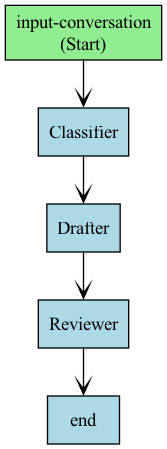

In [30]:
# 📐 Visualize the Sequential workflow structure
from agent_framework import WorkflowViz
from IPython.display import display, Image
import os

os.makedirs("images", exist_ok=True)
viz = WorkflowViz(seq_workflow)

png_path = viz.export(format="png", filename="images/sequential_workflow")
print("Sequential Pipeline (Classify → Draft → Review):")
display(Image(filename=png_path))

# 13. Concurrent Workflow

![Concurrent Workflow](images/concurrent-workflow.png)

InboxOps processes hundreds of emails per hour. Some tasks are **independent** — they don't need each other's output. Running them one after another wastes time.

**`ConcurrentBuilder`** distributes the **same input** to multiple agents simultaneously. Each agent works independently and in parallel. Results are collected once all agents finish.

---

### What is Fan-Out / Fan-In?

You'll hear the terms **fan-out** and **fan-in** in workflow literature. They describe exactly what `ConcurrentBuilder` does:

| Term | What it means | ConcurrentBuilder equivalent |
|------|--------------|------------------------------|
| **Fan-Out** | Broadcast one input to N workers | `.participants([agent1, agent2, agent3])` — all receive the same prompt |
| **Fan-In** | Collect all N results back into one | Default aggregation or `.with_aggregator(callback)` |

> **Think of it like email CC** — you send the same message to three people. Each replies independently. You read all replies and decide what to do. That's fan-out / fan-in.

`ConcurrentBuilder` handles both automatically. You don't need to manage fan-out/fan-in yourself — it's built in. The `.with_aggregator()` option lets you customize **how** results are combined (the fan-in step).

---

### When to Use Concurrent vs. Sequential

| Question | Sequential | Concurrent |
|----------|-----------|------------|
| Do agents depend on each other's output? | ✅ Yes — use sequential | ❌ No — use concurrent |
| Does order matter? | ✅ Yes — A must finish before B | ❌ No — all can run at once |
| Example | classify → draft → review | respond + summarize + tag |

### Key Concepts

| Concept | Description |
|---------|-------------|
| **`ConcurrentBuilder`** | Creates a parallel workflow — all agents run simultaneously |
| **`.participants([...])`** | List of agents that each receive the same input |
| **`.with_aggregator(fn)`** | Optional custom function to synthesize results |
| **`WorkflowOutputEvent`** | Final output containing aggregated messages from all agents |

## Basic: Parallel Respond + Summarize + Prioritize

The cell below defines three specialized agents and builds a `ConcurrentBuilder` workflow. All three process the same email simultaneously — no coordination needed.

In [31]:
from agent_framework import ConcurrentBuilder, WorkflowOutputEvent, AgentRunEvent

# --- Define three specialized agents that process the SAME email in parallel ---

# Agent 1: Drafts a response
concurrent_responder = chat_client.as_agent(
    name="Responder",
    instructions=(
        "You are an email response writer for InboxOps.\n"
        "Draft a professional reply to the email provided.\n"
        "Keep it concise — 2-3 sentences max.\n"
        "Start your output with '📬 DRAFT RESPONSE:'"
    ),
)

# Agent 2: Summarizes the email
concurrent_summarizer = chat_client.as_agent(
    name="Summarizer",
    instructions=(
        "You are an email summarizer for InboxOps.\n"
        "Provide a 1-2 sentence summary of the email's key point.\n"
        "Then list any action items.\n"
        "Start your output with '📋 SUMMARY:'"
    ),
)

# Agent 3: Assigns priority
concurrent_prioritizer = chat_client.as_agent(
    name="Prioritizer",
    instructions=(
        "You are a priority triage agent for InboxOps.\n"
        "Classify the email as: 🔴 URGENT, 🟡 NORMAL, or 🟢 LOW.\n"
        "Explain in one sentence why.\n"
        "Start your output with '🏷️ PRIORITY:'"
    ),
)

# --- Build the concurrent workflow ---
# All three agents receive the SAME input and run in parallel
concurrent_workflow = (
    ConcurrentBuilder()
    .participants([concurrent_responder, concurrent_summarizer, concurrent_prioritizer])
    .build()
)

print("✅ Concurrent workflow built — 3 agents will run in parallel")
print("   Participants: Responder, Summarizer, Prioritizer")

✅ Concurrent workflow built — 3 agents will run in parallel
   Participants: Responder, Summarizer, Prioritizer


## Run the Concurrent Workflow

The cell below streams the concurrent workflow and prints each agent's response. All three agents run **simultaneously** — total time is roughly equal to the slowest agent.

In [32]:
import time
from agent_framework import WorkflowOutputEvent

async def test_concurrent():
    email_text = f"From: {LEGIT_EMAIL.sender}\nSubject: {LEGIT_EMAIL.subject}\n\n{LEGIT_EMAIL.body}"
    
    print("=" * 60)
    print("⚡ CONCURRENT WORKFLOW — 3 agents processing in parallel")
    print("=" * 60)
    print(f"\n📧 Input email ({len(email_text)} chars):")
    print(f"   From: {LEGIT_EMAIL.sender}")
    print(f"   Subject: {LEGIT_EMAIL.subject}")
    print(f"\n{'─' * 60}\n")

    start_time = time.time()

    # Stream events from the concurrent workflow
    async for event in concurrent_workflow.run_stream(message=email_text):
        if isinstance(event, WorkflowOutputEvent):
            # Default output: list of ChatMessages (input + agent responses)
            messages = event.data
            if isinstance(messages, list):
                # Skip the first message (original user input), show agent responses
                agent_names = ["Responder", "Summarizer", "Prioritizer"]
                agent_responses = [m for m in messages if hasattr(m, "role") and str(m.role) != "user"]
                
                for i, msg in enumerate(agent_responses):
                    name = agent_names[i] if i < len(agent_names) else f"Agent {i+1}"
                    print(f"🤖 [{name}]")
                    print(f"   {msg.text}\n")

    elapsed = time.time() - start_time
    print("─" * 60)
    print(f"⏱️  Total parallel time: {elapsed:.2f}s")
    print(f"   (Sequential would take ~3x longer)")

await test_concurrent()

⚡ CONCURRENT WORKFLOW — 3 agents processing in parallel

📧 Input email (468 chars):
   From: sarah.chen@acmecorp.com
   Subject: Order #12345 - Delivery Issue

────────────────────────────────────────────────────────────

🤖 [Responder]
   📬 DRAFT RESPONSE:  
Hi Sarah,  

Thank you for reaching out. I apologize for the inconvenience with your order. We will investigate the delivery issue immediately and work on arranging a replacement for you as soon as possible.  

Best,  
[Your Name]  
InboxOps Support Team

🤖 [Summarizer]
   📋 SUMMARY: Sarah Chen is experiencing a delivery issue with order #12345, which shows it was delivered but she has not received it. She urgently requests assistance in locating the package or arranging a replacement since the items are needed for a client presentation on Friday.

**Action Items:**
1. Investigate the delivery status of order #12345.
2. Check with the shipping carrier for any discrepancies.
3. Arrange a replacement if the package cannot be located 

## Advanced: Custom Aggregator (Fan-In)

By default, `ConcurrentBuilder` collects all agent responses into a list. Use **`.with_aggregator(callback)`** to customize the fan-in step.

The cell below defines a `SupportTicket` dataclass, implements a `build_support_ticket` aggregator that extracts and combines agent outputs, and builds a new concurrent workflow with it.

In [33]:
import re
from dataclasses import dataclass, field
from agent_framework import AgentExecutorResponse

@dataclass
class SupportTicket:
    """Structured ticket synthesized from parallel agent outputs."""
    priority: str = "UNKNOWN"
    priority_emoji: str = "⚪"
    reason: str = ""
    summary: str = ""
    action_items: list[str] = field(default_factory=list)
    draft_response: str = ""
    agent_count: int = 0

    def render(self) -> str:
        actions = "\n".join(f"     {i+1}. {a}" for i, a in enumerate(self.action_items)) or "     None identified"
        return (
            f"┌─────────────────────────────────────────────────┐\n"
            f"│  {self.priority_emoji} SUPPORT TICKET — {self.priority:<10}            │\n"
            f"├─────────────────────────────────────────────────┤\n"
            f"│  📋 Summary                                     │\n"
            f"│  {self.summary[:70]:<70}│\n"
            f"├─────────────────────────────────────────────────┤\n"
            f"│  🎯 Action Items                                │\n"
            f"{actions}\n"
            f"├─────────────────────────────────────────────────┤\n"
            f"│  📬 Draft Response (ready to send)              │\n"
            f"{self.draft_response}\n"
            f"├─────────────────────────────────────────────────┤\n"
            f"│  ℹ️  Processed by {self.agent_count} agents in parallel      │\n"
            f"│  Priority reason: {self.reason[:50]:<50}│\n"
            f"└─────────────────────────────────────────────────┘"
        )


async def build_support_ticket(results: list[AgentExecutorResponse]) -> SupportTicket:
    """
    Fan-in aggregator: parse each agent's output and synthesize a structured ticket.
    
    This does real work — it extracts priority levels, parses action items,
    and reshapes raw agent text into a typed object.
    """
    ticket = SupportTicket(agent_count=len(results))

    for result in results:
        agent_name = result.executor_id
        text = result.agent_response.text

        if agent_name == "Prioritizer":
            # Extract priority level from emoji markers
            if "🔴" in text:
                ticket.priority, ticket.priority_emoji = "URGENT", "🔴"
            elif "🟡" in text:
                ticket.priority, ticket.priority_emoji = "NORMAL", "🟡"
            elif "🟢" in text:
                ticket.priority, ticket.priority_emoji = "LOW", "🟢"
            # Extract reason (text after the priority tag line)
            lines = text.strip().split("\n")
            ticket.reason = lines[-1].strip() if len(lines) > 1 else lines[0]

        elif agent_name == "Summarizer":
            # Extract summary (first sentence) and action items (numbered list)
            lines = text.strip().split("\n")
            summary_lines = []
            skip_prefixes = ("**action", "action item")
            for line in lines:
                stripped = line.strip()
                # Strip the 📋 SUMMARY: prefix but keep the content
                stripped = re.sub(r"^📋\s*SUMMARY:\s*", "", stripped)
                if stripped.startswith(("1.", "2.", "3.", "4.", "5.")):
                    ticket.action_items.append(re.sub(r"^\d+\.\s*", "", stripped))
                elif stripped.startswith("- "):
                    ticket.action_items.append(stripped[2:])
                elif stripped and not stripped.lower().startswith(skip_prefixes):
                    summary_lines.append(stripped)
            ticket.summary = " ".join(summary_lines)[:150]

        elif agent_name == "Responder":
            # Clean up the draft response text
            clean = text.replace("📬 DRAFT RESPONSE:", "").strip()
            ticket.draft_response = clean

    return ticket


# Build with the ticket aggregator
concurrent_ticket_workflow = (
    ConcurrentBuilder()
    .participants([concurrent_responder, concurrent_summarizer, concurrent_prioritizer])
    .with_aggregator(build_support_ticket)
    .build()
)

print("✅ Concurrent workflow with ticket aggregator built")
print("   Fan-out → 3 agents process email in parallel")
print("   Fan-in  → build_support_ticket() synthesizes a SupportTicket object")

✅ Concurrent workflow with ticket aggregator built
   Fan-out → 3 agents process email in parallel
   Fan-in  → build_support_ticket() synthesizes a SupportTicket object


In [34]:
async def test_ticket_aggregator():
    email_text = f"From: {LEGIT_EMAIL.sender}\nSubject: {LEGIT_EMAIL.subject}\n\n{LEGIT_EMAIL.body}"

    print("=" * 60)
    print("🎫 CONCURRENT → SUPPORT TICKET AGGREGATOR")
    print("=" * 60)
    print(f"\n📧 Incoming: {LEGIT_EMAIL.subject}\n")

    start_time = time.time()

    async for event in concurrent_ticket_workflow.run_stream(message=email_text):
        if isinstance(event, WorkflowOutputEvent):
            ticket: SupportTicket = event.data
            print(ticket.render())

    elapsed = time.time() - start_time
    print(f"\n⏱️  Total time: {elapsed:.2f}s  (3 agents ran concurrently)")
    print(f"📦 Output type: {type(ticket).__name__} — ready to push to queue")

await test_ticket_aggregator()

🎫 CONCURRENT → SUPPORT TICKET AGGREGATOR

📧 Incoming: Order #12345 - Delivery Issue

┌─────────────────────────────────────────────────┐
│  🔴 SUPPORT TICKET — URGENT                │
├─────────────────────────────────────────────────┤
│  📋 Summary                                     │
│  Sarah Chen reports that her order #12345 shows as delivered, but she h│
├─────────────────────────────────────────────────┤
│  🎯 Action Items                                │
     1. Investigate the delivery status of order #12345.
     2. Help locate the package or arrange for a replacement.
├─────────────────────────────────────────────────┤
│  📬 Draft Response (ready to send)              │
Hi Sarah, 

I'm sorry to hear about the issue with your order. We will investigate the delivery status immediately and keep you updated. If necessary, we will arrange a replacement to ensure you receive your items in time for your presentation.

Best,  
[Your Name]  
Support Team
├────────────────────────────────

Basic Concurrent (Fan-Out / Fan-In):


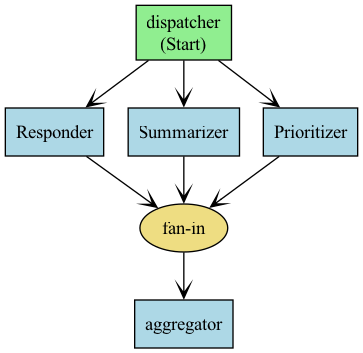


With Custom Aggregator:


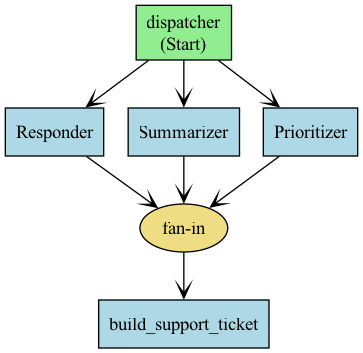

In [35]:
# 📐 Visualize the Concurrent workflow structures
viz_basic = WorkflowViz(concurrent_workflow)
viz_aggregator = WorkflowViz(concurrent_ticket_workflow)

print("Basic Concurrent (Fan-Out / Fan-In):")
png1 = viz_basic.export(format="png", filename="images/concurrent_basic")
display(Image(filename=png1))

print("\nWith Custom Aggregator:")
png2 = viz_aggregator.export(format="png", filename="images/concurrent_aggregator")
display(Image(filename=png2))

# 14. Group Chat

![Group Chat Pattern](images/group-chat.png)

Sequential runs agents in a fixed pipeline. Concurrent runs them independently. But what if agents need to **collaborate** — reviewing each other's work, building on each other's ideas, and iterating?

**`GroupChatBuilder`** creates an orchestrated conversation where agents take turns speaking while sharing the **full conversation history**. An orchestrator (either a simple function or an AI agent) decides who speaks next.

---

### How It Works

```
                    ┌──────────────┐
                    │ Orchestrator │  ← Decides who speaks next
                    └──────┬───────┘
                           │
            ┌──────────────┼──────────────┐
            ▼              ▼              ▼
     ┌────────────┐ ┌────────────┐ ┌────────────┐
     │  Agent A   │ │  Agent B   │ │  Agent C   │
     └────────────┘ └────────────┘ └────────────┘
            │              │              │
            └──────────────┼──────────────┘
                           ▼
                   Shared Conversation
```

Each agent sees **everything** said so far — including other agents' responses. This enables iterative refinement where later agents can address issues raised by earlier ones.

---

### InboxOps Use Case: Review Committee

Before sending any response, InboxOps enterprise drafts must pass through:
1. **Security review** — PII exposure, compliance violations
2. **Accuracy review** — unrealistic promises, unverified claims
3. **Final editor** — applies all feedback and produces the send-ready email

### Key Concepts

| Concept | Description |
|---------|-------------|
| **`GroupChatBuilder`** | Creates a group chat workflow with orchestrated speaker selection |
| **`.with_orchestrator()`** | Configure speaker selection: `selection_func=` for simple logic, `agent=` for AI-driven |
| **`.with_termination_condition()`** | Stop the conversation when a condition is met (e.g., N turns completed) |
| **`GroupChatState`** | Passed to selector — has `.current_round`, `.participants`, `.conversation` |
| **Shared Context** | Every agent sees the full conversation history including other agents' messages |

## Basic: Round-Robin Review Committee

The cell below defines three specialist agents (SecurityReviewer, AccuracyReviewer, ToneEditor) with `description` fields, builds a `GroupChatBuilder` with a round-robin `selection_func`, and runs it.

In [36]:
from agent_framework import GroupChatBuilder, GroupChatState

# --- Three specialist reviewers ---
# These agents are conversation-aware: they reference prior feedback, adapt
# when called again, and cross-check each other's findings. This design
# naturally rewards intelligent orchestration (where the orchestrator ensures
# the right context exists) and produces redundant output in round-robin
# (where no one manages the conversation flow).

security_reviewer = chat_client.as_agent(
    name="SecurityReviewer",
    description="Reviews for data exposure, PII leaks, and compliance issues",
    instructions=(
        "You are a security and compliance reviewer for InboxOps.\n\n"
        "FIRST CALL — analyze the draft for:\n"
        "- Data exposure risks (customer IDs, case numbers, internal references)\n"
        "- PII handling concerns\n"
        "- Policy compliance issues\n\n"
        "SUBSEQUENT CALLS — if the conversation already contains your previous review:\n"
        "- Check if ToneEditor's rewrite actually fixed the issues you flagged\n"
        "- Verify redactions were applied correctly (not just removed — masked)\n"
        "- Flag any NEW security issues introduced by the rewrite\n"
        "- Reference your original findings by number ('Issue #1 is now fixed, #2 remains')\n\n"
        "CROSS-REFERENCING: If AccuracyReviewer has flagged items, check whether "
        "those also have security implications (e.g., unauthorized compensation "
        "amounts being exposed).\n\n"
        "Be concise. Use numbered lists. Do NOT rewrite the email."
    ),
)

accuracy_reviewer = chat_client.as_agent(
    name="AccuracyReviewer",
    description="Reviews for factual accuracy, unrealistic promises, and timeline issues",
    instructions=(
        "You are a factual accuracy reviewer for InboxOps.\n\n"
        "FIRST CALL — analyze the draft for:\n"
        "- Unrealistic promises or timelines\n"
        "- Unverifiable claims about customer status or account details\n"
        "- Compensation that may not be authorized\n\n"
        "SUBSEQUENT CALLS — if the conversation already contains your previous review:\n"
        "- Check if ToneEditor's rewrite addressed your flagged items\n"
        "- Verify that softened language doesn't create NEW misleading implications\n"
        "  (e.g., 'we will prioritize' could still imply guaranteed speed)\n"
        "- Reference your original findings ('Item #1 fixed, #3 still problematic')\n\n"
        "CROSS-REFERENCING: If SecurityReviewer flagged data exposure, verify whether "
        "the exposed items were also factually incorrect (e.g., 'Premium customer' "
        "status that was both unverifiable AND a data leak).\n\n"
        "Be concise. Use numbered lists. Do NOT rewrite the email."
    ),
)

tone_editor = chat_client.as_agent(
    name="ToneEditor",
    description="Final editor — applies all feedback and produces the send-ready revised email",
    instructions=(
        "You are the final editor for InboxOps support responses.\n\n"
        "FIRST CALL:\n"
        "1. Read ALL feedback from SecurityReviewer and AccuracyReviewer in the conversation\n"
        "2. Produce a REVISED EMAIL that fixes every flagged issue:\n"
        "   - Redact sensitive data (mask, don't just delete)\n"
        "   - Replace unrealistic promises with honest, hedged language\n"
        "   - Remove unauthorized compensation or make it conditional\n"
        "   - Keep professional, empathetic tone\n\n"
        "SUBSEQUENT CALLS — if you've already produced a rewrite:\n"
        "- Read the NEW feedback from Security/Accuracy reviewers about your rewrite\n"
        "- Fix only the items they flagged as still problematic\n"
        "- Keep everything else unchanged — don't re-introduce old issues\n"
        "- Briefly note what you changed ('Fixed: removed case number, softened timeline')\n\n"
        "Output ONLY the final revised email. Start with 'Subject:'"
    ),
)

# Sample draft that has intentional issues for reviewers to catch
draft_to_review = """Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

I'm so sorry to hear about the missing package! This must be incredibly frustrating.

I've located your order and can confirm it was marked as delivered on Monday. Here's what I'll do:

1. I've opened an investigation with our shipping partner (Case #INV-789)
2. As a Premium customer, I'm expediting a replacement shipment TODAY
3. The replacement will arrive by Thursday, well before your Friday presentation

Your account has also been credited $50 for the inconvenience.

If you need anything else, reply directly to this email - I'm here to help!

Best regards,
Support Team"""

print("✅ Review committee defined (conversation-aware agents):")
print("   1. SecurityReviewer — flags issues, then verifies fixes on callback")
print("   2. AccuracyReviewer — flags issues, cross-references security findings")
print("   3. ToneEditor — applies feedback, then patches remaining issues on callback")
print(f"\n📝 Draft to review ({len(draft_to_review)} chars) — contains intentional issues")
print("\n💡 These agents reference prior conversation context — they work best")
print("   with an intelligent orchestrator that manages the review flow.")

✅ Review committee defined (conversation-aware agents):
   1. SecurityReviewer — flags issues, then verifies fixes on callback
   2. AccuracyReviewer — flags issues, cross-references security findings
   3. ToneEditor — applies feedback, then patches remaining issues on callback

📝 Draft to review (636 chars) — contains intentional issues

💡 These agents reference prior conversation context — they work best
   with an intelligent orchestrator that manages the review flow.


## Build & Run: Round-Robin Group Chat

A simple `selection_func` picks the next speaker based on the round index. The termination condition stops after all 3 reviewers have spoken once.

In [37]:
# Round-robin selector: cycles through participants in order
def round_robin_selector(state: GroupChatState) -> str:
    """Pick the next speaker based on round index."""
    participants = list(state.participants.keys())
    return participants[state.current_round % len(participants)]

# Build group chat — Security → Accuracy → ToneEditor (final)
review_group_chat = (
    GroupChatBuilder()
    .with_orchestrator(selection_func=round_robin_selector, orchestrator_name="RoundRobin")
    .participants([security_reviewer, accuracy_reviewer, tone_editor])
    .with_termination_condition(lambda msgs: sum(1 for m in msgs if m.role == Role.ASSISTANT) >= 3)
    .build()
)

print("✅ Group chat built with round-robin selection")
print("   Turn order: SecurityReviewer → AccuracyReviewer → ToneEditor")
print("   Terminates after 3 assistant messages (one per reviewer)")

✅ Group chat built with round-robin selection
   Turn order: SecurityReviewer → AccuracyReviewer → ToneEditor
   Terminates after 3 assistant messages (one per reviewer)


In [38]:
from agent_framework._workflows._events import AgentRunUpdateEvent

async def test_round_robin_review():
    print("=" * 60)
    print("🔄 ROUND-ROBIN GROUP CHAT — Review Committee")
    print("=" * 60)
    print(f"\n📝 Draft to review:\n{draft_to_review}\n")
    print("─" * 60)
    
    last_agent: str | None = None
    agent_order = []
    start_time = time.time()
    
    async for event in review_group_chat.run_stream(
        message=f"Review this support response and produce a final revised version:\n{draft_to_review}"
    ):
        if isinstance(event, AgentRunUpdateEvent):
            eid = event.executor_id
            if eid != last_agent:
                if last_agent is not None:
                    print("\n")
                agent_order.append(eid)
                emoji = {"SecurityReviewer": "🔒", "AccuracyReviewer": "✅", "ToneEditor": "✍️"}.get(eid, "🤖")
                print(f"{emoji} [{eid}] (Turn #{len(agent_order)}):", end=" ", flush=True)
                last_agent = eid
            print(event.data, end="", flush=True)
        
        elif isinstance(event, WorkflowOutputEvent):
            elapsed = time.time() - start_time
            print("\n\n" + "=" * 60)
            print(f"📊 Review complete in {elapsed:.1f}s")
            print(f"   Turn order: {' → '.join(agent_order)}")
            print(f"   Each reviewer saw all previous feedback (shared context)")
            print("=" * 60)

await test_round_robin_review()

🔄 ROUND-ROBIN GROUP CHAT — Review Committee

📝 Draft to review:
Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

I'm so sorry to hear about the missing package! This must be incredibly frustrating.

I've located your order and can confirm it was marked as delivered on Monday. Here's what I'll do:

1. I've opened an investigation with our shipping partner (Case #INV-789)
2. As a Premium customer, I'm expediting a replacement shipment TODAY
3. The replacement will arrive by Thursday, well before your Friday presentation

Your account has also been credited $50 for the inconvenience.

If you need anything else, reply directly to this email - I'm here to help!

Best regards,
Support Team

────────────────────────────────────────────────────────────
🔒 [SecurityReviewer] (Turn #1): 1. **Data Exposure Risks**:
   - The inclusion of order number (#12345) and case number (#INV-789) poses a data exposure risk. These identifiers can be sensitive and should be masked (e.g., Order #XXXX5, C

## Advanced: Agent-Based Orchestrator (AI Speaker Selection)

The cell below replaces `selection_func` with `.with_orchestrator(agent=ChatAgent)` — a full LLM reads the conversation and autonomously picks who speaks next. The termination condition ensures every participant speaks at least twice.

In [39]:
# ── Agent-Based Orchestrator ──────────────────────────────────────────
# Instead of selection_func, an AI agent picks the next speaker.
# No prescribed order — the orchestrator decides everything.
# The termination condition (>= 6 reviewer messages) ensures depth.

review_orchestrator = chat_client.as_agent(
    name="ReviewOrchestrator",
    description="Coordinates the review pipeline by selecting the next reviewer",
    instructions="""You coordinate a review committee for customer support emails.

PARTICIPANTS (use these exact names):
- SecurityReviewer: Checks for data leaks and PII exposure  
- AccuracyReviewer: Verifies factual claims and promises
- ToneEditor: Rewrites the email incorporating all feedback

You decide who speaks and in what order based on the draft's most urgent issues.
Every participant must speak at least twice — once for initial review and once to 
verify that ToneEditor's rewrite addressed their concerns. Never stop selecting 
participants until everyone has spoken at least twice.

Return ONLY the exact participant name. Nothing else."""
)

# ── Termination: every participant has spoken at least twice ──────────
PARTICIPANT_NAMES = {"SecurityReviewer", "AccuracyReviewer", "ToneEditor"}

def review_complete(msgs) -> bool:
    """Stop when every participant has spoken at least twice."""
    reviewer_msgs = [m for m in msgs if m.role == Role.ASSISTANT and len(str(m.text or "")) > 50]
    counts = {}
    for m in reviewer_msgs:
        if m.author_name in PARTICIPANT_NAMES:
            counts[m.author_name] = counts.get(m.author_name, 0) + 1
    return len(counts) == len(PARTICIPANT_NAMES) and all(c >= 2 for c in counts.values())

intelligent_review_chat = (
    GroupChatBuilder()
    .with_orchestrator(
        agent=review_orchestrator,
        orchestrator_name="ReviewCoordinator"
    )
    .participants([security_reviewer, accuracy_reviewer, tone_editor])
    .with_termination_condition(review_complete)
    .build()
)

print("✅ Intelligent review chat built with agent-based orchestrator")
print(f"   Orchestrator: {review_orchestrator.name} (AI-driven speaker selection)")
print(f"   Participants: SecurityReviewer, AccuracyReviewer, ToneEditor")
print(f"   Termination:  every participant has spoken at least twice")

# ── Run ───────────────────────────────────────────────────────────────
import time
from agent_framework._workflows._events import (
    AgentRunUpdateEvent, WorkflowOutputEvent,
)

REVIEWER_NAMES = {"SecurityReviewer", "AccuracyReviewer", "ToneEditor"}

async def test_agent_orchestrator():
    agent_emoji = {
        "SecurityReviewer": "🔒",
        "AccuracyReviewer": "📊",
        "ToneEditor": "✍️",
    }
    agent_calls = {}
    agent_sequence = []
    current_agent = None

    print("=" * 70)
    print("🧠 AGENT-BASED ORCHESTRATOR — AI Picks the Next Speaker")
    print("   No fixed order — the orchestrator decides autonomously")
    print("=" * 70)
    print(f"\n📧 Draft under review:\n{draft_to_review[:120]}...\n")
    print("-" * 70)

    start = time.time()

    async for event in intelligent_review_chat.run_stream(message=draft_to_review):

        if isinstance(event, AgentRunUpdateEvent):
            agent_id = event.executor_id

            # Only show reviewer output, skip orchestrator tokens
            if agent_id not in REVIEWER_NAMES:
                continue

            emoji = agent_emoji.get(agent_id, "🤖")

            # New reviewer speaking — print header
            if agent_id != current_agent:
                if current_agent:
                    print()

                agent_calls[agent_id] = agent_calls.get(agent_id, 0) + 1
                agent_sequence.append(agent_id)
                call_num = agent_calls[agent_id]
                is_callback = call_num > 1

                if is_callback:
                    print(f"\n{'━' * 70}")
                    print(f"  🔄 Round 2 — {agent_id} reviews the rewrite")
                    print(f"{'━' * 70}")
                    print(f"\n{emoji} [{agent_id}] (round 2):")
                else:
                    print(f"\n{emoji} [{agent_id}]:")

                print("  ", end="")
                current_agent = agent_id

            print(event.data, end="", flush=True)

        elif isinstance(event, WorkflowOutputEvent):
            elapsed = time.time() - start
            print(f"\n\n{'=' * 70}")
            print(f"✅ Review complete in {elapsed:.1f}s")

            # Flow
            print(f"\n📋 Flow (orchestrator chose this order):")
            parts = []
            for i, name in enumerate(agent_sequence):
                emoji = agent_emoji[name]
                call_num = sum(1 for a in agent_sequence[:i+1] if a == name)
                label = f"round {call_num}"
                parts.append(f"{emoji} {name} ({label})")
            print("   " + " → ".join(parts))

            # Summary
            print(f"\n📊 Summary:")
            for name in ["SecurityReviewer", "AccuracyReviewer", "ToneEditor"]:
                if name in agent_calls:
                    c = agent_calls[name]
                    emoji = agent_emoji[name]
                    bar = "█" * c
                    tag = " ← called back!" if c > 1 else ""
                    print(f"   {emoji} {name}: {bar} ({c}){tag}")

            total = sum(agent_calls.values())
            callbacks = sum(max(0, v - 1) for v in agent_calls.values())
            print(f"\n   Total: {total} turns, {callbacks} callback(s)")

await test_agent_orchestrator()

✅ Intelligent review chat built with agent-based orchestrator
   Orchestrator: ReviewOrchestrator (AI-driven speaker selection)
   Participants: SecurityReviewer, AccuracyReviewer, ToneEditor
   Termination:  every participant has spoken at least twice
🧠 AGENT-BASED ORCHESTRATOR — AI Picks the Next Speaker
   No fixed order — the orchestrator decides autonomously

📧 Draft under review:
Subject: Re: Order #12345 - Delivery Issue

Dear Sarah,

I'm so sorry to hear about the missing package! This must be in...

----------------------------------------------------------------------



🔒 [SecurityReviewer]:
  1. **Data Exposure Risks**: The provided order number (#12345) and case number (#INV-789) could potentially expose customer-related data if not properly managed. These should be masked or removed.

2. **PII Handling Concerns**: No direct Personally Identifiable Information (PII) such as names, addresses, or contact details are exposed in the body of the email. However, if this email is sent to unintended recipients, the presence of order and case numbers may still lead to indirect identification.

3. **Policy Compliance Issues**: The mention of the $50 credit does not specify if it conforms to company policy regarding compensation. Ensure that any compensatory measures are compliant with internal guidelines to avoid unauthorized promises. 

Overall, the email should carefully manage sensitive data to prevent exposure and ensure compliance with company policies.

📊 [AccuracyReviewer]:
  1. **Unrealistic Promises**: Claiming that the replacement shipment will arr


AI-Orchestrated Group Chat:


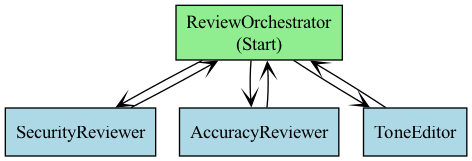

In [40]:
# 📐 Visualize the Group Chat workflow structures
viz_orchestrator = WorkflowViz(intelligent_review_chat)

print("\nAI-Orchestrated Group Chat:")
png2 = viz_orchestrator.export(format="png", filename="images/groupchat_orchestrated")
display(Image(filename=png2))

# 15. Magentic Orchestration

![Magentic Pattern](images/magentic-workflow.png)

InboxOps has reliable pipelines (sequential), fast parallel analysis (concurrent), and a review committee (group chat). But now stakeholders want something harder:

> *"Research last week's complaint patterns, analyze root causes, and produce an executive intelligence report."*

Nobody knows the steps upfront. Maybe the researcher finds a spike in shipping complaints, so the analyst needs to drill into that region. Maybe the analysis reveals a billing anomaly that needs more research. **The workflow path emerges as the task unfolds.**

This is where **Magentic orchestration** shines — a **manager agent** creates a plan, dynamically delegates to specialists, tracks progress, and iterates until the task is truly complete.

---

### Magentic vs. Group Chat — When to Use Each

Both patterns involve a set of agents coordinated by an orchestrator, but they solve fundamentally different problems:

| | **Group Chat** | **Magentic** |
|---|---|---|
| **Best for** | Iterative refinement of a *single artifact* | Open-ended tasks requiring *research + synthesis* |
| **Flow** | Conversation — agents respond to each other | Plan → Delegate → Execute → Assess → Iterate |
| **Planning** | None — orchestrator just picks the next speaker | Manager creates and updates a structured plan |
| **Progress tracking** | No built-in tracking | Progress ledger with stall/reset detection |
| **Shared context** | Full conversation history | Manager maintains task context and delegates subtasks |
| **Example** | Review committee editing a draft email | "Investigate complaint trends and write a report" |
| **Termination** | Condition on messages (e.g., everyone spoke twice) | Manager decides task is complete, or round limits hit |

**Rule of thumb:** If your agents are *talking to each other* about one thing → **Group Chat**. If a manager is *assigning work* across a multi-step investigation → **Magentic**.

---

### How It Works

```
                    ┌──────────────────┐
                    │  Manager Agent   │  ← Creates plan, tracks progress
                    └────────┬─────────┘
                             │
               ┌─────── Plan ───────┐
               │    & Delegate      │
               ▼                    ▼
        ┌─────────────┐     ┌─────────────┐
        │  Research    │     │  Analysis   │
        │  Agent      │     │  Agent      │
        └──────┬──────┘     └──────┬──────┘
               │                   │
               └───── Results ─────┘
                        │
                        ▼
               ┌─────────────────┐
               │ Manager assesses │
               │ progress & loops │
               │ or synthesizes   │
               └─────────────────┘
```

### Execution Flow

1. **Planning Phase** — Manager analyzes the task and creates a structured plan
2. **Agent Selection** — Manager picks the best agent for the current subtask
3. **Execution** — Selected agent does its work
4. **Progress Assessment** — Manager evaluates via a progress ledger
5. **Stall Detection** — If no progress, auto-replan (up to `max_stall_count`)
6. **Iteration** — Steps 2-5 repeat until complete or `max_round_count` hit
7. **Final Synthesis** — Manager combines everything into a final result

### Key Concepts

| Concept | Description |
|---------|-------------|
| **`MagenticBuilder`** | Creates a Magentic workflow with a planning manager |
| **`.with_manager(agent=)`** | Set the manager agent and tuning knobs |
| **`max_round_count`** | Maximum delegation rounds before forced completion |
| **`max_stall_count`** | How many stalls before the manager replans |
| **`MagenticOrchestratorEvent`** | Emitted when the manager makes planning decisions |
| **`MagenticProgressLedger`** | Structured progress tracking — who's next, why, what's done |
| **`.with_plan_review()`** | Enable human-in-the-loop plan approval before execution |

## Basic: InboxOps Weekly Support Intelligence Report

A complex, open-ended task requiring dynamic collaboration:
1. **ResearcherAgent** — Gathers complaint patterns and support data
2. **AnalystAgent** — Processes data, calculates metrics, identifies trends
3. **ResearchManager** — Plans the investigation, delegates subtasks, synthesizes the final report

The manager autonomously decides which agent to call, when, and how many times — based on evolving progress.

In [41]:
# Magentic Orchestration: Define specialized agents
import json
from typing import cast
from agent_framework import (
    ChatAgent,
    ChatMessage,
    MagenticBuilder,
    AgentRunUpdateEvent,
    MagenticOrchestratorEvent,
    MagenticProgressLedger,
    WorkflowOutputEvent,
)

# --- Specialized Agents ---

researcher_agent = ChatAgent(
    name="ResearcherAgent",
    description="Specialist in research and information gathering about support patterns and customer complaints",
    instructions="""You are an InboxOps Support Research Specialist.

YOUR ROLE:
- Gather information about customer complaint patterns
- Identify recurring issues and trends across support channels
- Provide realistic, detailed data based on common e-commerce support scenarios

When asked about support data, provide example data for categories like:
shipping delays, refund requests, product defects, billing disputes, account access issues.

Format data clearly in tables. Be concise and factual.""",
    chat_client=chat_client,
)

analyst_agent = ChatAgent(
    name="AnalystAgent",
    description="Data analyst who processes support data and creates operational insights with metrics",
    instructions="""You are an InboxOps Data Analyst.

YOUR ROLE:
- Process and analyze support ticket data provided by the researcher
- Calculate key metrics: volume trends, resolution times, escalation rates, CSAT impact
- Identify root causes and operational improvement opportunities
- Create clear summary tables with actionable recommendations

Show calculations step by step. Always tie findings back to business impact.""",
    chat_client=chat_client,
)

manager_agent = ChatAgent(
    name="ResearchManager",
    description="Orchestrator that plans and coordinates support intelligence workflows",
    instructions="""You manage an InboxOps research team to produce weekly support intelligence reports.

YOUR TEAM:
- ResearcherAgent: Gathers support data, complaint patterns, and trend information
- AnalystAgent: Processes data, calculates metrics, and produces actionable insights

Dynamically decide which agent to call based on what's needed next.
You may call agents multiple times if deeper investigation is required.""",
    chat_client=chat_client,
)

print("✅ Magentic agents defined: ResearcherAgent, AnalystAgent, ResearchManager")

✅ Magentic agents defined: ResearcherAgent, AnalystAgent, ResearchManager


### Build & Run

`MagenticBuilder` wires up the manager with tuning knobs:
- **`max_round_count`** — hard cap on delegation rounds (prevents infinite loops)
- **`max_stall_count`** — after N rounds with no progress, the manager replans

Watch the orchestrator events — you'll see the manager's planning decisions and progress tracking in real time.

In [42]:
# Build the Magentic workflow
magentic_workflow = (
    MagenticBuilder()
    .participants([researcher_agent, analyst_agent])
    .with_manager(
        agent=manager_agent,
        max_round_count=10,  # Max delegation rounds
        max_stall_count=3,   # Replan after 3 stalls
    )
    .build()
)

# The task — open-ended, requires research + analysis + synthesis
research_task = (
    "Produce the InboxOps weekly support intelligence report. "
    "Identify the top 5 complaint categories from the past week, "
    "estimate urgency and business impact for each, "
    "calculate resolution time trends, "
    "and provide 3 concrete operational improvement recommendations. "
    "Output a clean executive summary."
)

# Run with event streaming
last_message_id: str | None = None
agent_calls: dict[str, int] = {}
output_event: WorkflowOutputEvent | None = None

print("🔬 INBOXOPS SUPPORT INTELLIGENCE WORKFLOW")
print("=" * 60)

async for event in magentic_workflow.run_stream(research_task):
    # Stream agent output tokens
    if isinstance(event, AgentRunUpdateEvent):
        message_id = event.data.message_id
        executor_id = event.executor_id

        if message_id != last_message_id:
            if last_message_id is not None:
                print("\n")
            agent_calls[executor_id] = agent_calls.get(executor_id, 0) + 1
            emoji = {"ResearcherAgent": "🔍", "AnalystAgent": "📊"}.get(executor_id, "🤖")
            print(f"{emoji} [{executor_id}] (call #{agent_calls[executor_id]}):", end=" ", flush=True)
            last_message_id = message_id

        print(event.data, end="", flush=True)

    # Orchestrator planning events
    elif isinstance(event, MagenticOrchestratorEvent):
        print(f"\n\n{'─'*55}")
        print(f"📋 MANAGER EVENT: {event.event_type.name}")
        print(f"{'─'*55}")

        if isinstance(event.data, MagenticProgressLedger):
            # Progress ledger — show next speaker and reasoning
            ledger = event.data.to_dict()
            next_speaker = ledger.get("next_speaker", {})
            if isinstance(next_speaker, dict):
                print(f"   ➡️  Next agent: {next_speaker.get('answer', 'N/A')}")
                reason = next_speaker.get("reason", "")
                if reason:
                    print(f"   💭 Reason: {reason[:150]}")
            is_done = ledger.get("is_request_satisfied", {})
            if isinstance(is_done, dict):
                print(f"   ✅ Request satisfied: {is_done.get('answer', 'N/A')}")

        elif isinstance(event.data, ChatMessage):
            # Plan created / replanned — show the actual plan text
            plan_text = event.data.text or ""
            if plan_text:
                # Show a condensed version of the plan
                lines = plan_text.strip().split("\n")
                for line in lines[:15]:  # Show first 15 lines
                    print(f"   {line}")
                if len(lines) > 15:
                    print(f"   ... ({len(lines) - 15} more lines)")

    # Capture final output
    elif isinstance(event, WorkflowOutputEvent):
        output_event = event

# --- Summary ---
print("\n\n" + "=" * 60)
print("📊 EXECUTION SUMMARY")
print("=" * 60)
total = sum(agent_calls.values())
print(f"   Total agent delegations: {total}")
for agent_name, count in sorted(agent_calls.items()):
    emoji = {"ResearcherAgent": "🔍", "AnalystAgent": "📊"}.get(agent_name, "🤖")
    print(f"   {emoji} {agent_name}: {count} call(s)")

# Display final report
if output_event:
    output_messages = cast(list[ChatMessage], output_event.data)
    final_text = output_messages[-1].text if output_messages else "No output"
    print("\n" + "=" * 60)
    print("📑 FINAL INTELLIGENCE REPORT")
    print("=" * 60)
    print(final_text)

🔬 INBOXOPS SUPPORT INTELLIGENCE WORKFLOW


───────────────────────────────────────────────────────
📋 MANAGER EVENT: PLAN_CREATED
───────────────────────────────────────────────────────
   We are working to address the following user request:
   
   Produce the InboxOps weekly support intelligence report. Identify the top 5 complaint categories from the past week, estimate urgency and business impact for each, calculate resolution time trends, and provide 3 concrete operational improvement recommendations. Output a clean executive summary.
   
   
   To answer this request we have assembled the following team:
   
   - ResearcherAgent: Specialist in research and information gathering about support patterns and customer complaints
   - AnalystAgent: Data analyst who processes support data and creates operational insights with metrics
   
   
   Here is an initial fact sheet to consider:
   
   1. GIVEN OR VERIFIED FACTS
      - The request is to produce a weekly support intelligence repo

## Advanced: Human-in-the-Loop Plan Review with a Multi-Phase Investigation

The basic task above is fairly straightforward. But Magentic really shines when the **solution path isn't known upfront** and the manager needs to send agents back multiple times as new information emerges.

Here we give the manager a deliberately complex, multi-phase task:
1. First, **research** complaint patterns broadly
2. Then **analyze** to find the worst category
3. But the analysis reveals a need for **more research** into root causes
4. The analyst then needs the new data to **calculate financial impact**
5. Only then can the manager produce the final report

This back-and-forth delegation is exactly what separates Magentic from simpler patterns.

We also enable **`.with_plan_review()`** — the manager proposes a plan, and your code can **approve** or **revise** it before execution begins. For group-chat-based orchestrations (Group Chat and Magentic), the orchestrator can also request human feedback and approvals as needed.

### Key Types

| Type | Description |
|------|-------------|
| `RequestInfoEvent` | Emitted when the manager wants plan approval |
| `MagenticPlanReviewRequest` | The plan data — access `.plan.text` for the proposed plan |
| `.approve()` | Accept the plan as-is |
| `.revise(feedback)` | Send feedback — manager will replan |
| `workflow.send_responses_streaming()` | Resume the workflow with the user's decision |

In [43]:
# Advanced: Magentic with a complex multi-phase task + plan review
from agent_framework import (
    MagenticPlanReviewRequest,
    MagenticPlanReviewResponse,
    RequestInfoEvent,
)

# Build with plan review enabled
magentic_workflow_hitl = (
    MagenticBuilder()
    .participants([researcher_agent, analyst_agent])
    .with_manager(
        agent=manager_agent,
        max_round_count=15,   # More rounds for a complex task
        max_stall_count=3,
    )
    .with_plan_review()  # ← Enables human approval checkpoint
    .build()
)

# A deliberately complex task that forces multiple back-and-forth delegations.
# The manager can't just do research-then-analysis — the analysis will reveal
# gaps that require more research, which then needs further analysis.
hitl_task = (
    "InboxOps needs an urgent executive briefing for the board meeting tomorrow. "
    "Investigate the following:\n"
    "1. Research the top complaint categories from the past week and their volumes\n"
    "2. Analyze which single category has the highest business impact (consider volume, "
    "revenue risk, and customer churn potential)\n"
    "3. For that worst category, research the specific root causes — what's actually going wrong "
    "operationally? (e.g., supplier issues, process failures, staffing gaps)\n"
    "4. Analyze the financial exposure: estimate weekly revenue at risk, projected churn rate, "
    "and cost of inaction over 30 days\n"
    "5. Research what competitor best practices exist for handling this category\n"
    "6. Produce a final board-ready executive briefing with: problem summary, financial impact, "
    "root cause analysis, 3 prioritized recommendations with estimated ROI, and a 30-day action plan"
)

# --- Run with plan review handling ---
pending_request: RequestInfoEvent | None = None
pending_responses: dict[str, MagenticPlanReviewResponse] | None = None
output_event: WorkflowOutputEvent | None = None
agent_calls: dict[str, int] = {}

print("🔬 MAGENTIC — MULTI-PHASE INVESTIGATION + PLAN REVIEW")
print("=" * 60)

while not output_event:
    if pending_responses is not None:
        stream = magentic_workflow_hitl.send_responses_streaming(pending_responses)
    else:
        stream = magentic_workflow_hitl.run_stream(hitl_task)

    last_message_id: str | None = None

    async for event in stream:
        if isinstance(event, AgentRunUpdateEvent):
            message_id = event.data.message_id
            executor_id = event.executor_id

            if message_id != last_message_id:
                if last_message_id is not None:
                    print("\n")
                agent_calls[executor_id] = agent_calls.get(executor_id, 0) + 1
                emoji = {"ResearcherAgent": "🔍", "AnalystAgent": "📊"}.get(executor_id, "🤖")
                print(f"{emoji} [{executor_id}] (call #{agent_calls[executor_id]}):", end=" ", flush=True)
                last_message_id = message_id

            print(event.data, end="", flush=True)

        elif isinstance(event, RequestInfoEvent) and event.request_type is MagenticPlanReviewRequest:
            pending_request = event

        elif isinstance(event, MagenticOrchestratorEvent):
            print(f"\n{'─'*55}")
            print(f"📋 MANAGER: {event.event_type.name}")

            if isinstance(event.data, MagenticProgressLedger):
                ledger = event.data.to_dict()
                next_speaker = ledger.get("next_speaker", {})
                if isinstance(next_speaker, dict):
                    print(f"   ➡️  Next: {next_speaker.get('answer', 'N/A')}")
                    reason = next_speaker.get("reason", "")
                    if reason:
                        print(f"   💭 Why: {reason[:150]}")
                is_done = ledger.get("is_request_satisfied", {})
                if isinstance(is_done, dict):
                    print(f"   ✅ Done: {is_done.get('answer', 'N/A')}")

            elif isinstance(event.data, ChatMessage):
                plan_text = event.data.text or ""
                if plan_text:
                    lines = plan_text.strip().split("\n")
                    for line in lines[:15]:
                        print(f"   {line}")
                    if len(lines) > 15:
                        print(f"   ... ({len(lines) - 15} more lines)")

            print(f"{'─'*55}")

        elif isinstance(event, WorkflowOutputEvent):
            output_event = event

    pending_responses = None

    # Handle plan review request
    if pending_request is not None:
        event_data = cast(MagenticPlanReviewRequest, pending_request.data)

        print("\n\n" + "=" * 60)
        print("🔍 PLAN REVIEW REQUEST")
        print("=" * 60)

        if event_data.current_progress is not None:
            progress = event_data.current_progress.to_dict()
            print("📊 Current Progress:")
            print(json.dumps(progress, indent=2))
            print()

        print(f"📋 Proposed Plan:\n{event_data.plan.text}\n")

        # Auto-approve for notebook (in production: present to user and use revise)
        print("✅ Auto-approving plan for demo purposes")
        print("   (In production: user can call event_data.revise('feedback') to replan)")
        pending_responses = {pending_request.request_id: event_data.approve()}
        pending_request = None

# --- Final Report ---
print("\n\n" + "=" * 60)
print("📊 EXECUTION SUMMARY")
print("=" * 60)
total = sum(agent_calls.values())
print(f"   Total agent delegations: {total}")
for name, count in sorted(agent_calls.items()):
    emoji = {"ResearcherAgent": "🔍", "AnalystAgent": "📊"}.get(name, "🤖")
    print(f"   {emoji} {name}: {count} call(s)")
print(f"\n   💡 Notice: The manager called agents multiple times,")
print(f"      going back to ResearcherAgent as AnalystAgent's findings")
print(f"      revealed the need for deeper investigation.")

if output_event:
    output_messages = cast(list[ChatMessage], output_event.data)
    final_text = output_messages[-1].text if output_messages else "No output"
    print("\n" + "=" * 60)
    print("📑 EXECUTIVE BRIEFING (Plan-Reviewed)")
    print("=" * 60)
    print(final_text)

🔬 MAGENTIC — MULTI-PHASE INVESTIGATION + PLAN REVIEW

───────────────────────────────────────────────────────
📋 MANAGER: PLAN_CREATED
   We are working to address the following user request:
   
   InboxOps needs an urgent executive briefing for the board meeting tomorrow. Investigate the following:
   1. Research the top complaint categories from the past week and their volumes
   2. Analyze which single category has the highest business impact (consider volume, revenue risk, and customer churn potential)
   3. For that worst category, research the specific root causes — what's actually going wrong operationally? (e.g., supplier issues, process failures, staffing gaps)
   4. Analyze the financial exposure: estimate weekly revenue at risk, projected churn rate, and cost of inaction over 30 days
   5. Research what competitor best practices exist for handling this category
   6. Produce a final board-ready executive briefing with: problem summary, financial impact, root cause analysis, 


Magentic with Plan Review


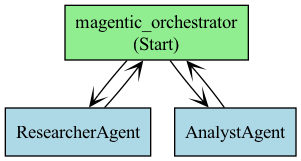

In [44]:
# 📐 Visualize the Magentic workflow structures
viz_hitl = WorkflowViz(magentic_workflow_hitl)

print("\nMagentic with Plan Review")
png2 = viz_hitl.export(format="png", filename="images/magentic_hitl")
display(Image(filename=png2))

# 16. Handoff Orchestration

![Handoff Orchestration](https://learn.microsoft.com/en-us/agent-framework/user-guide/workflows/resources/images/orchestration-handoff.png)

## How It Works

In a **Handoff** orchestration, agents transfer control to one another based on context — there is **no central orchestrator**. Each agent can decide when to hand the conversation off to another specialist, creating dynamic, peer-to-peer routing. This is fundamentally different from the other orchestrations we've built so far:

| Aspect | Handoff | Sequential / Group Chat |
|--------|---------|------------------------|
| **Control Flow** | Agents pass control to each other directly | Orchestrator / fixed order manages flow |
| **Task Ownership** | Receiving agent takes **full ownership** | Orchestrator retains responsibility |
| **Context** | Full conversation history shared across all agents | Varies by orchestration type |
| **Topology** | Mesh — agents form a peer network | Star / chain — central coordinator |

## Core API

| Method | Purpose |
|--------|---------|
| `HandoffBuilder(name, participants)` | Create a handoff workflow with specialist agents |
| `.with_start_agent(agent)` | Set which agent receives user input first |
| `.add_handoff(source, [targets])` | Define custom routing rules (who can hand off to whom) |
| `.with_termination_condition(fn)` | Custom logic to decide when the workflow completes |
| `.with_autonomous_mode()` | Agents continue without waiting for human input |
| `HandoffAgentUserRequest.create_response(text)` | Send user reply when an agent pauses for input |
| `HandoffAgentUserRequest.terminate()` | End the workflow early from the user side |

## InboxOps Use Case: Multi-Department Email Escalation

Real support inboxes don't have a single agent that handles everything. Instead, emails flow through **multiple departments** depending on the issue:

```
Customer Email
    ↓
┌─────────────┐
│  Triage     │  ← Reads the email, classifies the issue
└──────┬──────┘
       ├──→ Billing Agent      (payment disputes, invoices, subscription changes)
       ├──→ Account Agent      (password resets, access, account closures)
       └──→ Compliance Agent   (data requests, GDPR, legal escalations)
```

Each specialist has **domain-specific tools** and can **escalate to other departments** when the issue crosses boundaries — e.g. a billing dispute that reveals a security breach gets escalated from Billing → Accounts → Compliance. The triage agent never touches the issue itself; it only routes.

This is exactly what **handoff** is designed for — no central brain re-reads every message; agents hand off ownership entirely.

In [45]:
from typing import Annotated
from collections import defaultdict
from agent_framework import (
    HandoffBuilder,
    HandoffAgentUserRequest,
    RequestInfoEvent,
    WorkflowOutputEvent,
    tool,
)

# ═══════════════════════════════════════════════════════════════════════════
# TOOL TRACKER — records every tool invocation for the output trace
# ═══════════════════════════════════════════════════════════════════════════

tool_log: list[dict] = []   # [{tool, args, result}, ...]

# ═══════════════════════════════════════════════════════════════════════════
# TOOLS — each department has domain-specific capabilities
# ═══════════════════════════════════════════════════════════════════════════

@tool
def lookup_invoice(customer_id: Annotated[str, "Customer ID e.g. CUST-002"]) -> str:
    """Look up all billing and invoice records for a customer."""
    invoices = {
        "CUST-001": "Invoice #INV-4821 | $299/mo Enterprise | Status: Active",
        "CUST-002": (
            "Account: CUST-002 (Sarah Chen) | Plan: Starter $49/mo\n"
            "Recent charges:\n"
            "  • Feb 1 — $49.00 (Starter renewal) — DECLINED ❌ (card expired)\n"
            "  • Jan 18 — $299.00 (Enterprise upgrade) — CHARGED ✅\n"
            "⚠️ ALERT: Customer is on Starter ($49/mo). The $299 Enterprise charge "
            "does NOT match their plan — possible unauthorized transaction."
        ),
    }
    result = invoices.get(customer_id, f"No invoices found for {customer_id}")
    tool_log.append({"tool": "lookup_invoice", "args": f"customer_id={customer_id}", "result": result})
    return result

@tool
def reset_account_access(
    customer_id: Annotated[str, "Customer ID"],
    action: Annotated[str, "Action: unlock, reset_password, or revoke_sessions"],
) -> str:
    """Perform account security actions."""
    result = {
        "revoke_sessions": f"✅ All sessions for {customer_id} terminated.",
        "unlock": f"✅ Account {customer_id} unlocked.",
        "reset_password": f"✅ Password reset link sent to {customer_id}'s email.",
    }.get(action, f"Unknown action: {action}")
    tool_log.append({"tool": "reset_account_access", "args": f"{customer_id}, action={action}", "result": result})
    return result

@tool
def file_compliance_ticket(
    customer_id: Annotated[str, "Customer ID"],
    request_type: Annotated[str, "Type: breach_report, data_export, data_deletion, or legal_hold"],
    description: Annotated[str, "Brief incident description"],
) -> str:
    """File a compliance ticket. Only file what's relevant to the actual incident."""
    ticket_id = f"COMP-{hash(customer_id + request_type) % 10000:04d}"
    if request_type == "breach_report":
        result = (
            f"🚨 Ticket {ticket_id}: Breach report filed for {customer_id}.\n"
            f"   Incident: {description}\n"
            f"   Response team notified (SLA: 1h). Refund in 5-7 business days."
        )
    else:
        result = f"Ticket {ticket_id}: {request_type} filed for {customer_id}."
    tool_log.append({"tool": "file_compliance_ticket", "args": f"{customer_id}, type={request_type}", "result": result})
    return result

# ═══════════════════════════════════════════════════════════════════════════
# AGENTS — 4 specialists forming the InboxOps handoff chain
# ═══════════════════════════════════════════════════════════════════════════

inbox_triage = chat_client.as_agent(
    name="inbox_triage",
    instructions=(
        "You are the InboxOps Triage Agent. Read the email and route to the right department.\n"
        "You NEVER resolve issues — only route.\n\n"
        "Rules:\n"
        "• Billing disputes, unauthorized charges → inbox_billing\n"
        "• Account locked, password, login → inbox_accounts\n"
        "• GDPR/legal data requests → inbox_compliance\n\n"
        "Multiple issues? Route to billing first (it can escalate further).\n"
        "State which department and why, then hand off immediately."
    ),
    description="Triage — routes emails to the correct department.",
)

inbox_billing = chat_client.as_agent(
    name="inbox_billing",
    instructions=(
        "You are the Billing Specialist. Handle payment disputes and unauthorized charges.\n\n"
        "IMPORTANT: You MUST use the lookup_invoice tool to check the customer's records.\n"
        "1. Call lookup_invoice with the customer ID\n"
        "2. Analyze the results and report your findings\n"
        "3. If unauthorized activity is confirmed → hand off to inbox_accounts to secure the account\n\n"
        "Do NOT fix account issues yourself. Do NOT say 'You're welcome'."
    ),
    description="Billing — investigates charges. Escalates to accounts if fraud found.",
    tools=[lookup_invoice],
)

inbox_accounts = chat_client.as_agent(
    name="inbox_accounts",
    instructions=(
        "You are the Account Security Specialist. Secure compromised accounts.\n\n"
        "IMPORTANT: You MUST use the reset_account_access tool for ALL three actions:\n"
        "1. Call reset_account_access with action='revoke_sessions' — log out unauthorized users\n"
        "2. Call reset_account_access with action='unlock' — restore customer access\n"
        "3. Call reset_account_access with action='reset_password' — send reset link\n"
        "4. After all three tool calls, summarize what you did\n"
        "5. Hand off to inbox_compliance for the breach report\n\n"
        "Do NOT skip any tool calls. Do NOT say 'You're welcome'."
    ),
    description="Accounts — secures accounts. Escalates to compliance.",
    tools=[reset_account_access],
)

inbox_compliance = chat_client.as_agent(
    name="inbox_compliance",
    instructions=(
        "You are the Compliance Specialist. Handle breach reports.\n\n"
        "IMPORTANT: You MUST use the file_compliance_ticket tool.\n"
        "1. Call file_compliance_ticket with request_type='breach_report' and a clear description\n"
        "2. Provide a final summary of ALL actions taken across ALL departments\n"
        "3. End with 'You're welcome!'\n\n"
        "ONLY file breach_report. Do NOT file data_export/data_deletion/legal_hold "
        "unless the customer explicitly asked."
    ),
    description="Compliance — files breach reports. Final stop.",
    tools=[file_compliance_ticket],
)

# ═══════════════════════════════════════════════════════════════════════════
# BUILD — handoff workflow with autonomous mode
# ═══════════════════════════════════════════════════════════════════════════

inbox_handoff_workflow = (
    HandoffBuilder(
        name="inboxops_email_handoff",
        participants=[inbox_triage, inbox_billing, inbox_accounts, inbox_compliance],
    )
    .with_start_agent(inbox_triage)
    .add_handoff(inbox_triage, [inbox_billing, inbox_accounts, inbox_compliance])
    .add_handoff(inbox_billing, [inbox_accounts, inbox_compliance, inbox_triage])
    .add_handoff(inbox_accounts, [inbox_billing, inbox_compliance, inbox_triage])
    .add_handoff(inbox_compliance, [inbox_triage])
    .with_termination_condition(
        lambda msgs: len(msgs) > 0 and "you're welcome" in msgs[-1].text.lower()
    )
    .with_autonomous_mode(
        agents=[inbox_triage, inbox_billing, inbox_accounts, inbox_compliance],
        prompts={
            "inbox_triage": "Route this email to the correct department now.",
            "inbox_billing": "Use the lookup_invoice tool to investigate the customer's billing records.",
            "inbox_accounts": "Use reset_account_access to: revoke_sessions, unlock, and reset_password.",
            "inbox_compliance": "Use file_compliance_ticket to file a breach_report, then summarize.",
        },
        turn_limits={"inbox_triage": 2, "inbox_billing": 4,
                      "inbox_accounts": 6, "inbox_compliance": 2},
    )
    .build()
)

print("✅ InboxOps handoff workflow built — 4 agents, autonomous mode\n")

# ═══════════════════════════════════════════════════════════════════════════
# RUN — Unauthorized charge escalation scenario
#
# Expected chain: Triage → Billing → Accounts → Compliance
# Each agent uses its tools before handing off to the next.
# ═══════════════════════════════════════════════════════════════════════════

escalation_email = (
    "Subject: Unauthorized charge and locked account — URGENT\n\n"
    "Hi Support,\n\n"
    "I'm Sarah Chen, customer ID CUST-002. Two issues:\n\n"
    "1. UNAUTHORIZED CHARGE: My bank shows a $299 charge from your platform on Jan 18. "
    "I'm on the $49/mo Starter Plan and never upgraded. I did NOT authorize this.\n\n"
    "2. ACCOUNT LOCKED: I can't log into my dashboard — it says my account is locked. "
    "I think someone accessed my account and made the unauthorized upgrade.\n\n"
    "Please investigate the charge, secure my account, and file an incident report.\n\n"
    "Thanks,\nSarah Chen (CUST-002)"
)

icons = {"inbox_triage": "📋", "inbox_billing": "💳",
         "inbox_accounts": "🔐", "inbox_compliance": "⚖️"}
labels = {"inbox_triage": "Triage", "inbox_billing": "Billing",
          "inbox_accounts": "Accounts", "inbox_compliance": "Compliance"}

# Map tools to their owning agent for the trace
tool_owners = {
    "lookup_invoice": "inbox_billing",
    "reset_account_access": "inbox_accounts",
    "file_compliance_ticket": "inbox_compliance",
}

print("=" * 70)
print("📨 INCOMING EMAIL:")
print("=" * 70)
print(escalation_email)
print("=" * 70)
print("🔄 HANDOFF TRACE:")
print("=" * 70 + "\n")

tool_log.clear()  # reset tracker
handoff_chain = ["inbox_triage"]
final_response = None

async for event in inbox_handoff_workflow.run_stream(escalation_email):
    etype = type(event).__name__

    # ── Handoff routing ──
    if etype == "HandoffSentEvent":
        target = getattr(event, 'target_executor_id', None) or getattr(event, 'target', None)
        if target:
            source = handoff_chain[-1]
            handoff_chain.append(str(target))
            print(f"  {icons.get(source, '📧')} {labels.get(source, source)} "
                  f"──handoff──▶ {icons.get(str(target), '📧')} {labels.get(str(target), str(target))}")

    # ── Final agent paused for user input ──
    elif isinstance(event, RequestInfoEvent) and isinstance(event.data, HandoffAgentUserRequest):
        for msg in event.data.agent_response.messages:
            text = getattr(msg, 'text', None)
            if text and text != escalation_email and len(text) > 10:
                final_response = (getattr(msg, 'author_name', 'unknown'), text)
        event.data.terminate()

# ═══════════════════════════════════════════════════════════════════════════
# OUTPUT — Clean, readable trace showing tools + responses + routing
# ═══════════════════════════════════════════════════════════════════════════

# Remove trailing triage loop-back
display_chain = list(handoff_chain)
if len(display_chain) > 1 and display_chain[-1] == display_chain[0]:
    display_chain = display_chain[:-1]

# Show tool activity — grouped by agent, in chain order
print(f"\n{'─'*70}")
print("  🔧 TOOL ACTIVITY:")
print(f"{'─'*70}")
seen_calls = set()
for agent_id in display_chain:
    agent_tools = [t for t in tool_log if tool_owners.get(t["tool"]) == agent_id]
    if not agent_tools:
        continue
    icon = icons.get(agent_id, "📧")
    label = labels.get(agent_id, agent_id)
    for entry in agent_tools:
        call_key = (entry["tool"], entry["args"])
        if call_key in seen_calls:
            continue
        seen_calls.add(call_key)
        first_line = entry["result"].split("\n")[0][:100]
        print(f"  {icon} {label} → {entry['tool']}({entry['args']})")
        print(f"     ↳ {first_line}")

# Final response (full text from the last agent)
if final_response:
    author, text = final_response
    icon = icons.get(author, "📧")
    label = labels.get(author, author)
    print(f"\n{'─'*70}")
    print(f"  {icon} Final Response from {label}:")
    print(f"{'─'*70}")
    for line in text.split("\n"):
        print(f"  {line}")

# Routing chain summary
print(f"\n{'─'*70}")
chain_str = " → ".join(f"{icons.get(a, '📧')} {labels.get(a, a)}" for a in display_chain)
print(f"  Route: {chain_str}")
unique_calls = len(seen_calls)
print(f"  Tool calls: {unique_calls}")

print(f"\n{'='*70}")
print(f"✅ InboxOps handoff complete — {len(set(display_chain))} departments, {unique_calls} tool calls")
print(f"{'='*70}")

✅ InboxOps handoff workflow built — 4 agents, autonomous mode

📨 INCOMING EMAIL:
Subject: Unauthorized charge and locked account — URGENT

Hi Support,

I'm Sarah Chen, customer ID CUST-002. Two issues:

1. UNAUTHORIZED CHARGE: My bank shows a $299 charge from your platform on Jan 18. I'm on the $49/mo Starter Plan and never upgraded. I did NOT authorize this.

2. ACCOUNT LOCKED: I can't log into my dashboard — it says my account is locked. I think someone accessed my account and made the unauthorized upgrade.

Please investigate the charge, secure my account, and file an incident report.

Thanks,
Sarah Chen (CUST-002)
🔄 HANDOFF TRACE:

  📋 Triage ──handoff──▶ 💳 Billing
  💳 Billing ──handoff──▶ 🔐 Accounts
  🔐 Accounts ──handoff──▶ ⚖️ Compliance

──────────────────────────────────────────────────────────────────────
  🔧 TOOL ACTIVITY:
──────────────────────────────────────────────────────────────────────
  💳 Billing → lookup_invoice(customer_id=CUST-002)
     ↳ Account: CUST-002 (Sarah C

InboxOps Handoff — 4 agents with cross-department escalation


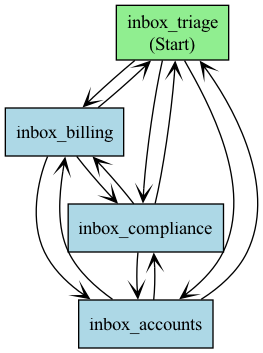

In [46]:
# 📐 Visualize the InboxOps Handoff workflow
from agent_framework import WorkflowViz
from IPython.display import display, Image

viz_handoff = WorkflowViz(inbox_handoff_workflow)
print("InboxOps Handoff — 4 agents with cross-department escalation")
png_handoff = viz_handoff.export(format="png", filename="images/handoff_inboxops")
display(Image(filename=png_handoff))

# 17. Workflow Checkpointing & Recovery

![Checkpointing](https://learn.microsoft.com/agent-framework/user-guide/workflows/resources/images/checkpointing.png)

It's **Cyber Monday** at InboxOps. The team needs to process **10,000 customer emails** in a batch workflow. Each email goes through:

1. **Classify** (spam, urgent, general)
2. **Draft Response** (using AI)
3. **Quality Check** (grammar, tone)
4. **Send** (log to CRM)

**The Problem**: Processing all 10K emails takes 2 hours. If the server crashes at email 7,843, they'd have to **restart from zero** — wasting time and money.

**The Solution**: **Workflow Checkpointing** — save progress at intervals and **resume from the last checkpoint** after failures.

## What is Checkpointing?

Checkpointing allows workflows to:

- **Save state** at specific points (super steps)
- **Resume execution** after process restarts or failures
- **Persist executor state** (e.g., processed email count, partial results)
- **Rehydrate workflows** from checkpoints to new instances

## Key Benefits

✅ **Fault Tolerance** — Recover from server crashes, network issues  
✅ **Long-Running Processes** — Process thousands of items reliably  
✅ **Cost Efficiency** — Don't re-process completed work  
✅ **Debugging** — Inspect workflow state at specific points  
✅ **Human-in-the-Loop** — Pause for approvals, resume later

## When to Use Checkpointing

| Scenario | Why Checkpointing Helps |
|----------|------------------------|
| **Batch Processing** | Resume from failure in 10K email processing |
| **Multi-Stage Pipelines** | Save progress after each stage |
| **Approval Workflows** | Pause for human approval, resume later |
| **Resource-Intensive Tasks** | Stop/restart workflows based on resource availability |
| **Debugging** | Time-travel to specific workflow states |

## InboxOps Use Case

InboxOps processes emails in batches of 100. After each batch:

1. **Checkpoint created** automatically
2. **Progress saved** (emails processed, drafts generated)
3. **If server crashes**, workflow resumes from last completed batch

**Result**: 10K emails processed with zero data loss, even during infrastructure failures.

In [ ]:
from agent_framework import (
    WorkflowBuilder,
    Executor,
    WorkflowContext,
    handler,
    FileCheckpointStorage,
    get_checkpoint_summary,
)
from pathlib import Path
from typing import Any, override
from dataclasses import dataclass, field

# === Data Models ===

@dataclass
class BatchTask:
    """Represents a batch of emails to process."""
    batch_id: int
    emails: list[str]
    total_batches: int

@dataclass
class ProcessedBatch:
    """Result of processing a batch."""
    batch_id: int
    processed_count: int
    responses: list[str]

# === Email Batch Processor Executor (with State Persistence) ===

class EmailBatchProcessor(Executor):
    """Processes email batches with checkpoint state persistence."""
    
    def __init__(self, executor_id: str) -> None:
        super().__init__(id=executor_id)
        self._processed_batches: list[int] = []
        self._total_emails_processed = 0
    
    @handler
    async def process_batch(
        self,
        task: BatchTask,
        ctx: WorkflowContext[BatchTask, dict[str, Any]],
    ) -> None:
        """Process a batch of emails."""
        print(f"\n📧 Processing Batch {task.batch_id}/{task.total_batches}...")
        
        # Simulate email processing
        responses = []
        for i, email in enumerate(task.emails, 1):
            # Simulate processing (in real world, call agent)
            response = f"Response to: {email[:30]}..."
            responses.append(response)
            print(f"  ✓ Processed email {i}/{len(task.emails)}")
        
        # Update state
        self._processed_batches.append(task.batch_id)
        self._total_emails_processed += len(task.emails)
        
        print(f"✅ Batch {task.batch_id} complete ({self._total_emails_processed} emails total)")
        
        # Output final results if all batches done
        if len(self._processed_batches) == task.total_batches:
            await ctx.yield_output({
                "total_batches": len(self._processed_batches),
                "total_emails": self._total_emails_processed,
                "status": "complete"
            })
        else:
            # Continue to next batch (in real world, send next task)
            print(f"⏭️  Ready for next batch...")
    
    @override
    async def on_checkpoint_save(self) -> dict[str, Any]:
        """Save executor state for checkpointing."""
        print(f"�� CHECKPOINT: Saving state (batches: {self._processed_batches})")
        return {
            "processed_batches": self._processed_batches,
            "total_emails_processed": self._total_emails_processed,
        }
    
    @override
    async def on_checkpoint_restore(self, state: dict[str, Any]) -> None:
        """Restore executor state from checkpoint."""
        self._processed_batches = state.get("processed_batches", [])
        self._total_emails_processed = state.get("total_emails_processed", 0)
        print(f"♻️  RESTORED: {len(self._processed_batches)} batches ({self._total_emails_processed} emails)")

# === Setup Checkpoint Storage ===

checkpoint_dir = Path("./inboxops_checkpoints")
checkpoint_dir.mkdir(exist_ok=True)
checkpoint_storage = FileCheckpointStorage(storage_path=str(checkpoint_dir))

print(f"✅ Checkpoint storage initialized: {checkpoint_dir}")

In [ ]:
# === Build Workflow with Checkpointing ===

batch_processor = EmailBatchProcessor(executor_id="batch_processor")

# Enable checkpointing by passing checkpoint_storage to WorkflowBuilder
checkpoint_workflow = (
    WorkflowBuilder(
        start_executor=batch_processor,
        checkpoint_storage=checkpoint_storage,  # 🔑 Enable checkpointing
        max_iterations=10,
    )
    .build()
)

print("✅ Workflow built with checkpointing enabled")

# === Simulate Processing 3 Batches (with automatic checkpointing) ===

print("\n=== InboxOps Batch Email Processing (with Checkpointing) ===\n")

# Simulate 300 emails in 3 batches of 100 each
emails_batch1 = [f"Email {i}: Customer inquiry about order #{1000+i}" for i in range(1, 101)]
emails_batch2 = [f"Email {i}: Return request for product XYZ" for i in range(101, 201)]
emails_batch3 = [f"Email {i}: Shipping question for international order" for i in range(201, 301)]

# Process batch 1
task1 = BatchTask(batch_id=1, emails=emails_batch1, total_batches=3)
result1 = await checkpoint_workflow.run(task1)

# List checkpoints created
checkpoints = await checkpoint_storage.list_checkpoints()
print(f"\n📊 Checkpoints created so far: {len(checkpoints)}")

for cp in checkpoints:
    summary = get_checkpoint_summary(cp)
    print(f"  • Checkpoint {summary.checkpoint_id[:8]}... (iteration {summary.iteration_count})")

In [ ]:
# === Simulate Server Crash & Resume ===

print("\n⚠️  SIMULATING SERVER CRASH (processing paused)...\n")
print("🔄 RESUMING from last checkpoint...\n")

# Get the latest checkpoint
checkpoints = await checkpoint_storage.list_checkpoints()
if checkpoints:
    latest_checkpoint = max(checkpoints, key=lambda cp: cp.timestamp)
    print(f"📍 Resuming from checkpoint: {latest_checkpoint.checkpoint_id[:12]}...")
    
    # Resume workflow from checkpoint
    async for event in checkpoint_workflow.run_stream(
        checkpoint_id=latest_checkpoint.checkpoint_id,
        checkpoint_storage=checkpoint_storage
    ):
        if event.type == "executor_completed":
            print(f"  ✓ Executor completed: {event.executor_id}")
        elif event.type == "output":
            print(f"\n🎉 Workflow resumed and completed!")
            print(f"   Final result: {event.data}")
            break
        elif event.type == "checkpoint_saved":
            print(f"  💾 Checkpoint saved after resume")
else:
    print("❌ No checkpoints available to resume from")

# Show final checkpoint stats
all_checkpoints = await checkpoint_storage.list_checkpoints()
print(f"\n=== Final Checkpoint Summary ===")
print(f"Total Checkpoints: {len(all_checkpoints)}")
print(f"\n�� InboxOps Benefits:")
print(f"   • Server crashed? Resume from last checkpoint ✅")
print(f"   • 7,843 emails processed? Don't restart from 0 ✅")
print(f"   • Automatic state persistence ✅")
print(f"   • Zero data loss ✅")

## Advanced: Listing & Inspecting Checkpoints

InboxOps supervisors can **inspect checkpoint history** to debug workflow issues or analyze processing performance.

In [ ]:
# === List and Inspect Checkpoints ===

from datetime import datetime

checkpoints = await checkpoint_storage.list_checkpoints()

print("\n=== InboxOps Checkpoint History ===\n")
print(f"{'Checkpoint ID':<15} {'Iteration':<12} {'Timestamp':<20}")
print("-" * 50)

for cp in sorted(checkpoints, key=lambda c: c.timestamp):
    summary = get_checkpoint_summary(cp)
    cp_id = summary.checkpoint_id[:12] + "..."
    timestamp = datetime.fromtimestamp(cp.timestamp).strftime("%Y-%m-%d %H:%M:%S")
    print(f"{cp_id:<15} {summary.iteration_count:<12} {timestamp:<20}")

print(f"\n📊 Total checkpoints: {len(checkpoints)}")
print(f"\n💡 Use these checkpoints to:")
print(f"   • Resume after failures")
print(f"   • Debug workflow issues at specific points")
print(f"   • Analyze processing performance over time")
print(f"   • Time-travel to any workflow state")

## Key Takeaways

| Feature | Description | InboxOps Benefit |
|---------|-------------|------------------|
| **FileCheckpointStorage** | Persistent JSON-based storage | Survives server restarts |
| **Automatic Checkpoints** | Created at super step boundaries | No manual checkpoint code needed |
| **State Persistence** | Executors save/restore state | Resume with full context |
| **Resume Modes** | Streaming or non-streaming | Flexible recovery options |
| **Rehydration** | Load checkpoint into new workflow | Testing and debugging |

## Production Best Practices

1. **Checkpoint Retention** — Delete old checkpoints to save disk space
2. **Monitoring** — Track checkpoint creation rate and storage usage
3. **Testing** — Test recovery paths in staging environments
4. **Alerting** — Alert when workflows fail to create checkpoints
5. **Documentation** — Document checkpoint schema for debugging

With checkpointing, InboxOps can process millions of emails reliably, recovering from any failure without losing progress. 🚀